In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')


!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
# import libraries

import os
import shutil
import tempfile
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    RandAffined,
    ToTensord,


)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import VNet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1

degree_min = -1
degree_max = 1

roi_type="face_"

split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"


root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),

        ToTensord(keys=["image", "label"]),
    ]
)



In [ ]:
# load the files based on the lists in json

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


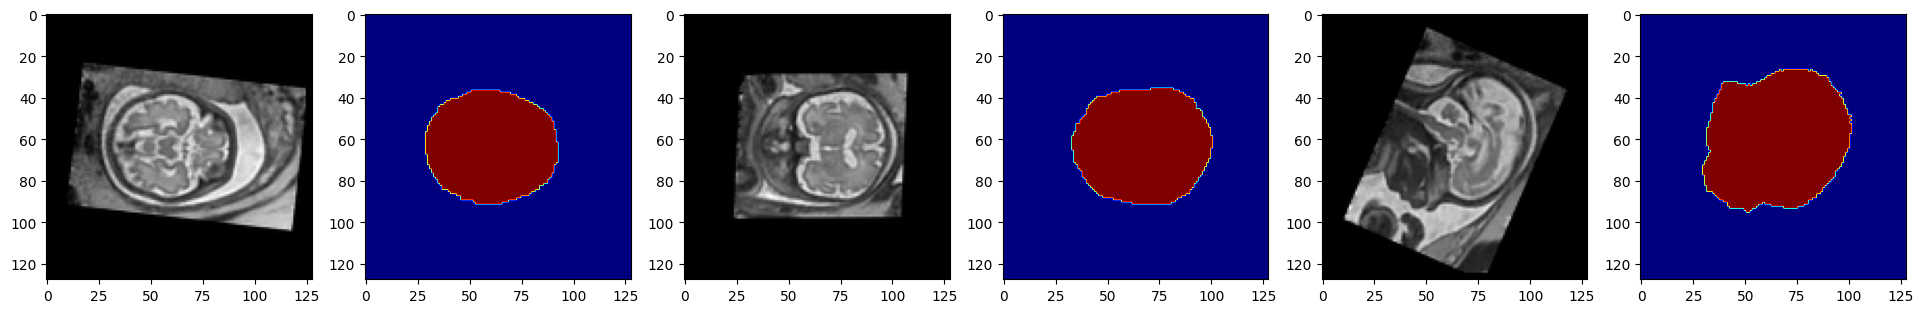

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


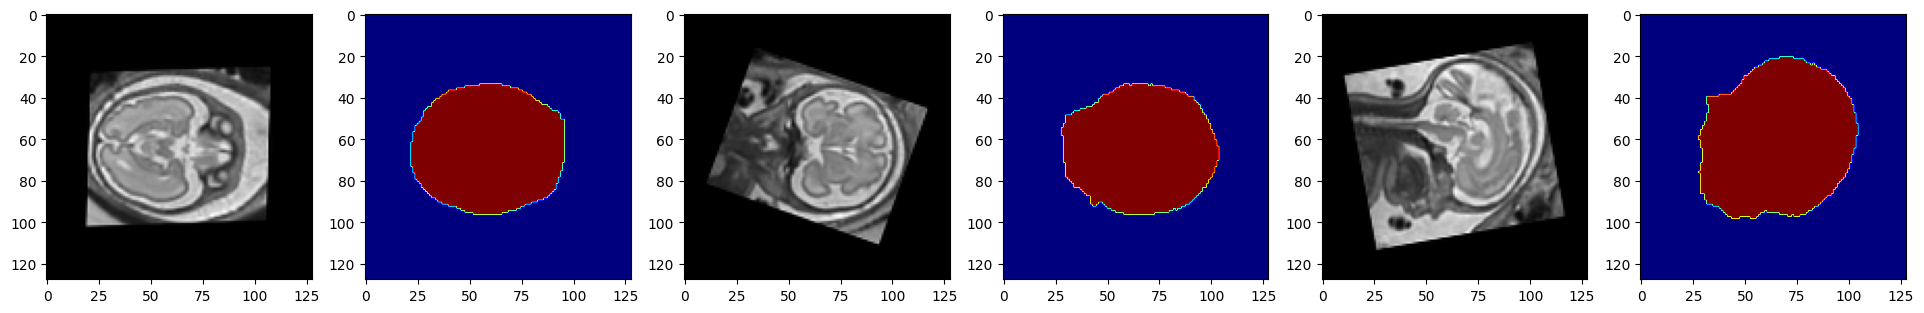

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


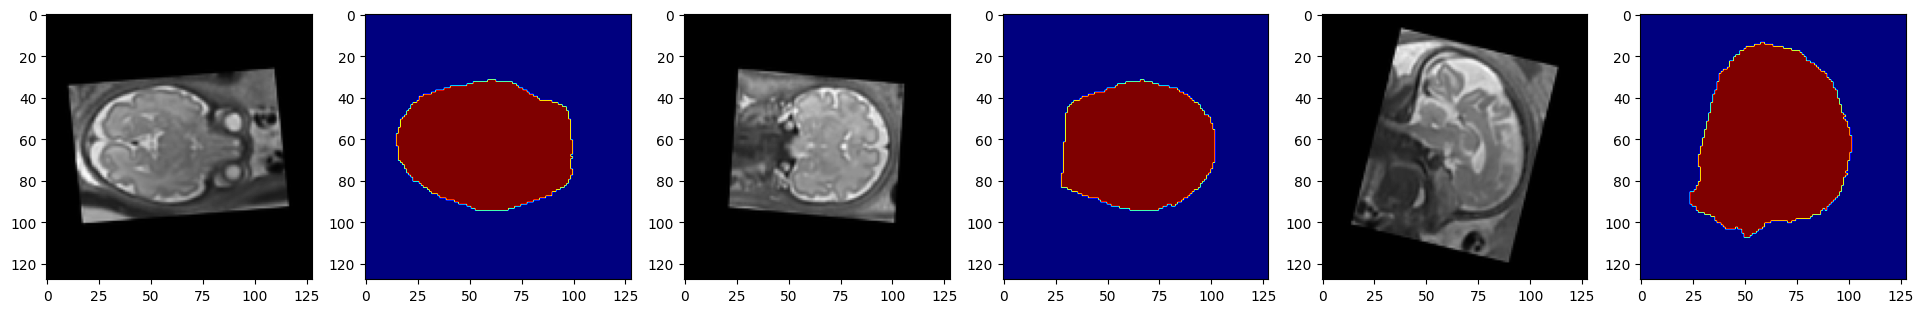

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


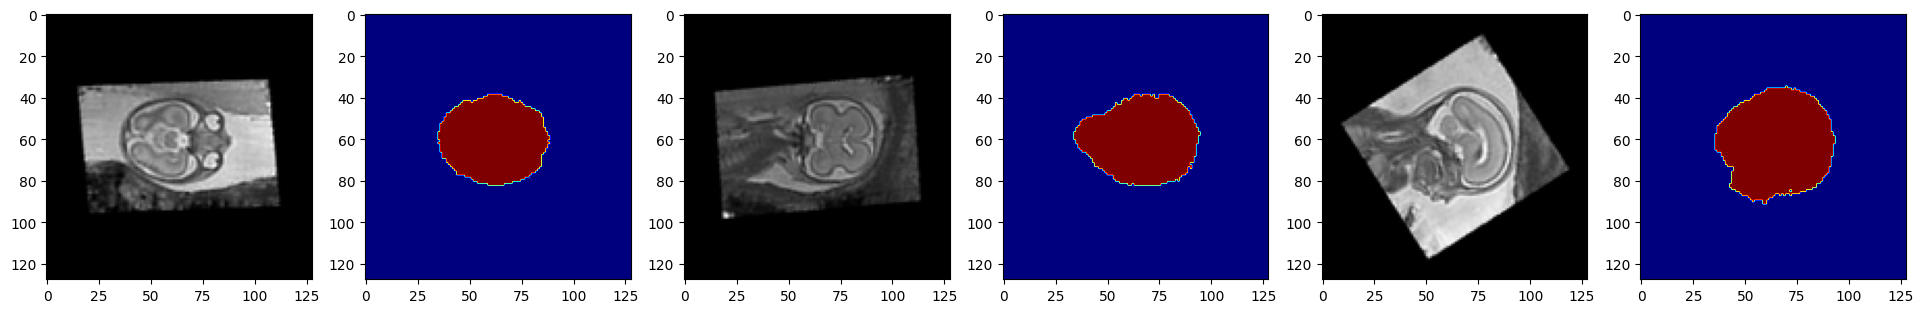

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


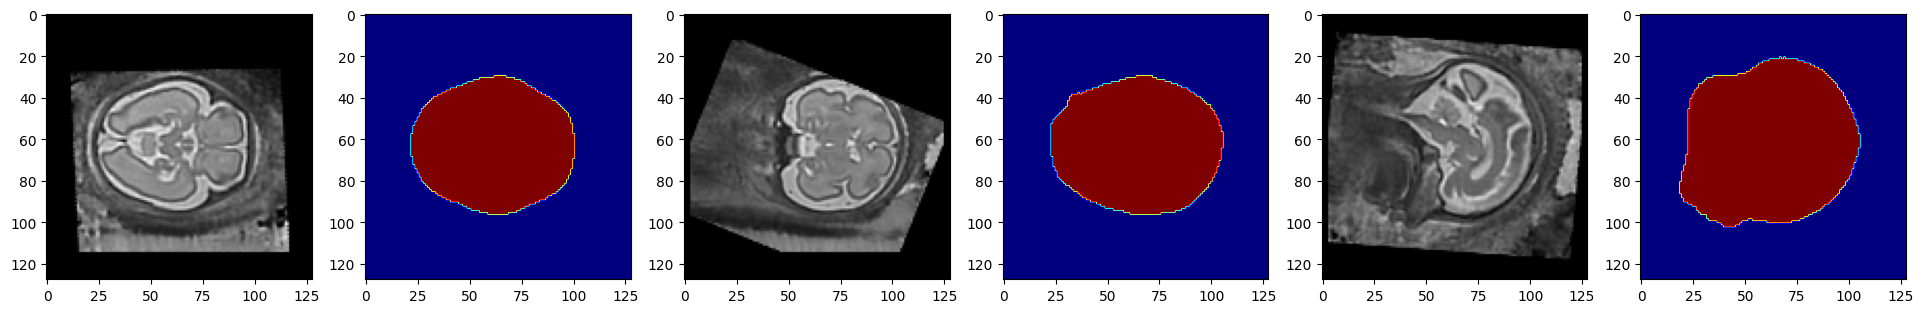

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


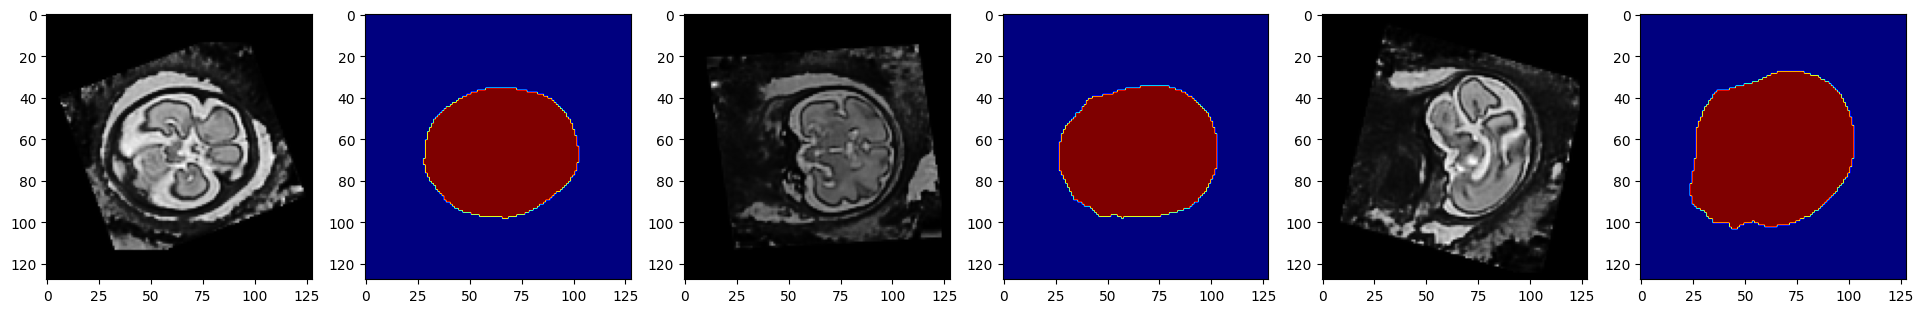

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


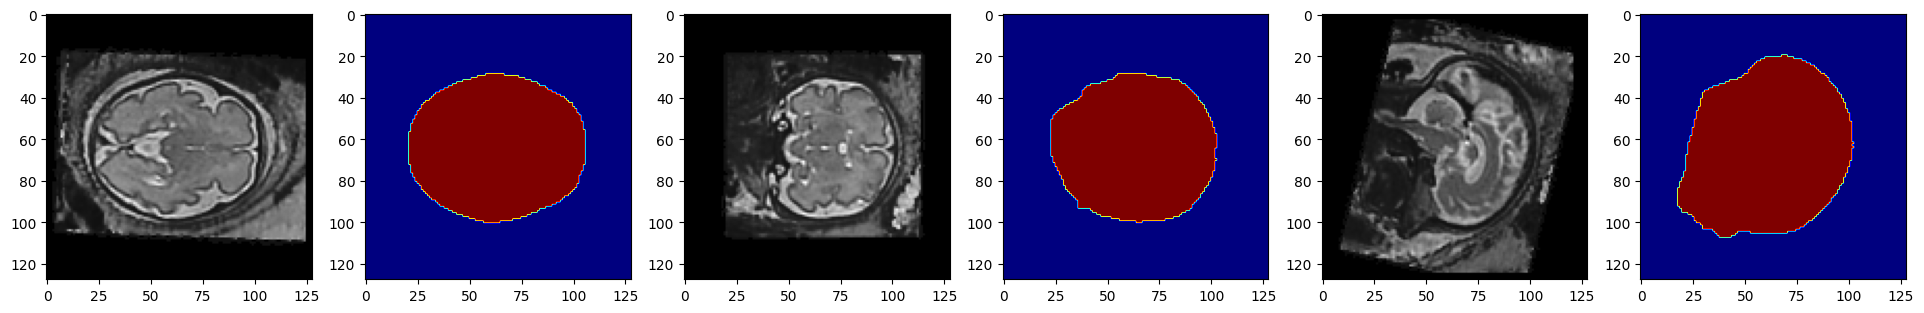

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


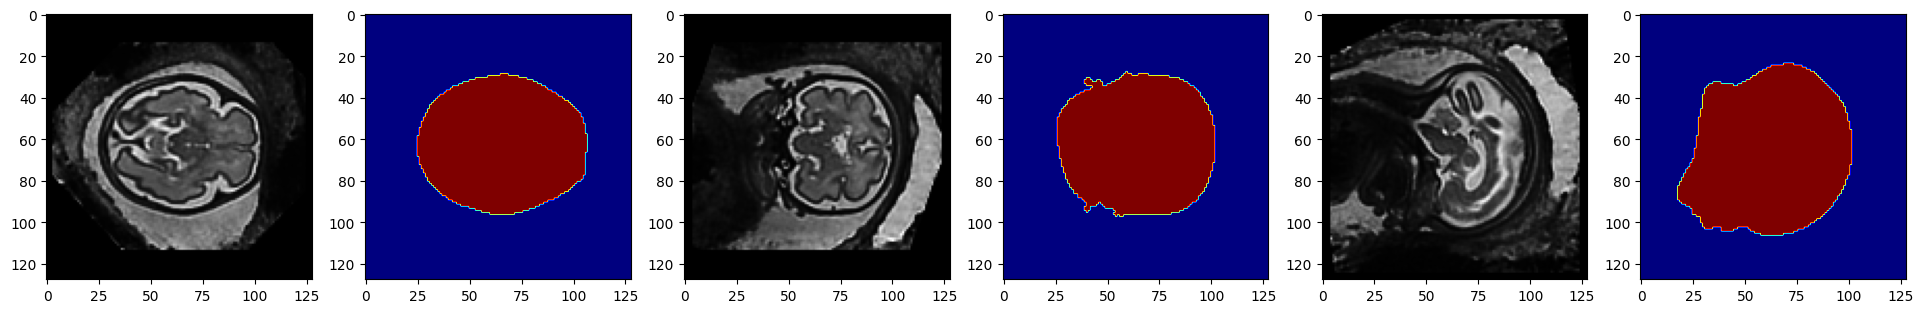

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


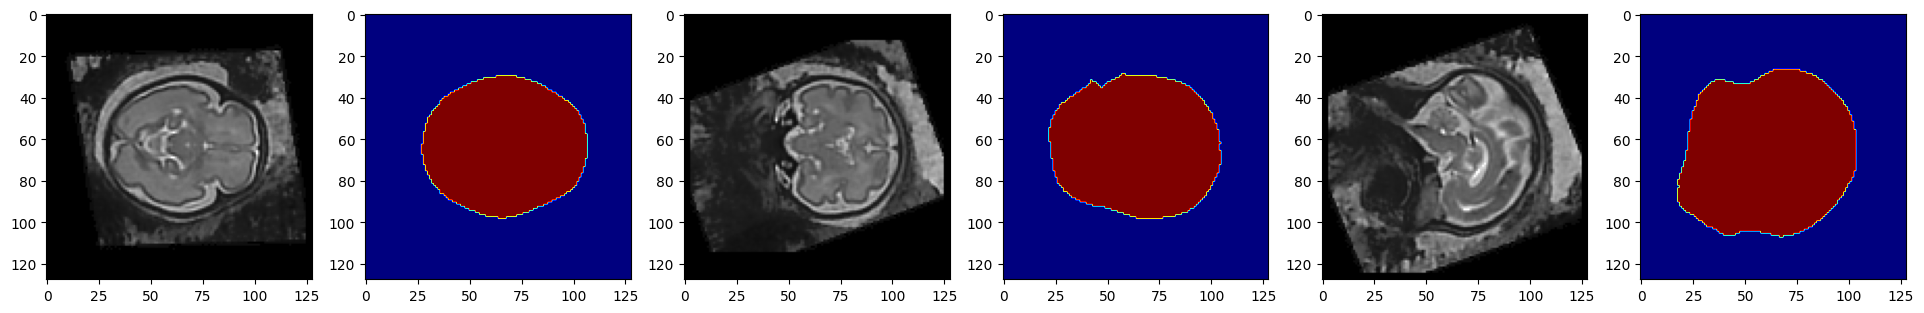

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


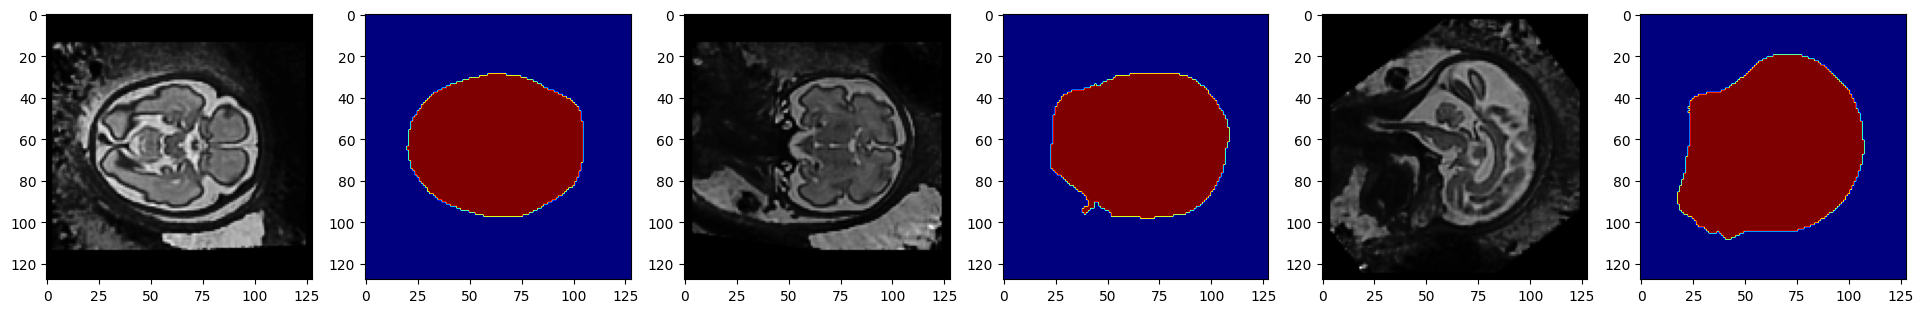

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


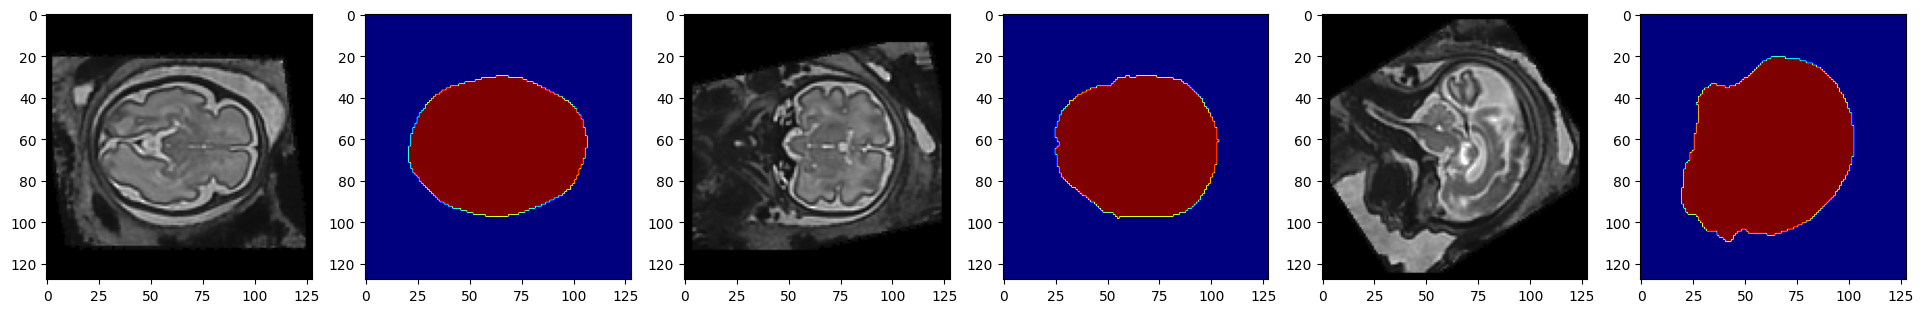

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


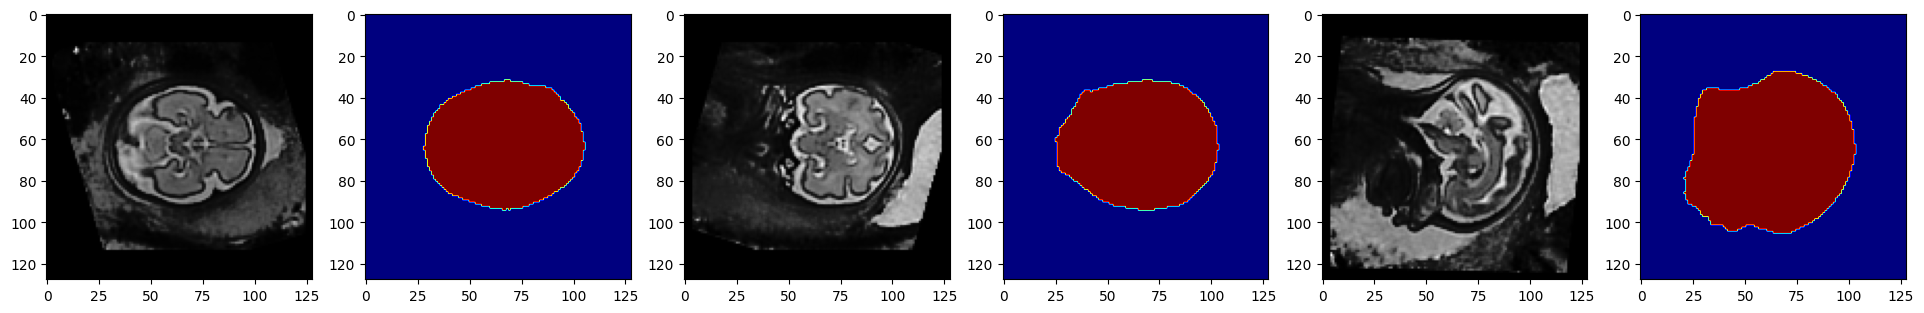

In [ ]:
s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()

In [ ]:
# define the network using MONAI

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VNet(spatial_dims=3, in_channels=1, out_channels=class_num,
             act=('elu', {'inplace': True}),
             dropout_dim=3, bias=False).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            #CHANGE PER MODEL
            epoch_loss_values_vnet_no_aug.append(epoch_loss)
            #CHANGE PER MODEL
            metric_values_vnet_no_aug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                #CHANGE PER MODEL
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_no_aug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              #CHANGE PER MODEL
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_no_aug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
epoch_loss_values_vnet_no_aug = []
metric_values_vnet_no_aug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=0.79759): 100%|██████████| 82/82 [04:13<00:00,  3.09s/it]



Total Training Time: 4.23 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=0.66566): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Validate (164 / 10 Steps) (dice=0.85780): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Patience Counter has Been Reset


Training (200 / 30000 Steps) (loss=0.63831):  45%|████▌     | 37/82 [01:11<02:45,  3.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.800000453988711 Current Avg. Dice: 0.800000453988711
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.27585): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=0.62330): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Validate (328 / 10 Steps) (dice=0.92936): 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Patience Counter has Been Reset


Training (400 / 30000 Steps) (loss=0.52803):  89%|████████▉ | 73/82 [02:14<00:34,  3.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9175938914219538 Current Avg. Dice: 0.9175938914219538
Epochs Without Improvement:0


Training (409 / 30000 Steps) (loss=0.37672): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=0.59327): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=0.58282): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Validate (574 / 10 Steps) (dice=0.93826): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Patience Counter has Been Reset


Training (600 / 30000 Steps) (loss=0.72374):  33%|███▎      | 27/82 [00:53<03:25,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9318334112564722 Current Avg. Dice: 0.9318334112564722
Epochs Without Improvement:0


Training (655 / 30000 Steps) (loss=0.13563): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.51724): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Training (800 / 30000 Steps) (loss=0.52655):  77%|███████▋  | 63/82 [01:55<01:08,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9318334112564722 Current Avg. Dice: 0.905169149239858
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (819 / 30000 Steps) (loss=0.19856): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.53542): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=0.48449): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Training (1000 / 30000 Steps) (loss=0.49182):  21%|██        | 17/82 [00:36<03:56,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9318334112564722 Current Avg. Dice: 0.9257282465696335
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (1065 / 30000 Steps) (loss=0.09014): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.47530): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Training (1200 / 30000 Steps) (loss=0.45211):  65%|██████▍   | 53/82 [01:38<01:46,  3.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9318334112564722 Current Avg. Dice: 0.8847716003656387
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (1229 / 30000 Steps) (loss=0.23419): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.66760): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.40631): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Training (1400 / 30000 Steps) (loss=0.64705):   9%|▊         | 7/82 [00:18<04:47,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9318334112564722 Current Avg. Dice: 0.9294682045777639
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (1475 / 30000 Steps) (loss=0.15776): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.49 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.38478): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Validate (1558 / 10 Steps) (dice=0.95351): 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Patience Counter has Been Reset


Training (1600 / 30000 Steps) (loss=0.42724):  52%|█████▏    | 43/82 [01:21<02:20,  3.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9426124493281046 Current Avg. Dice: 0.9426124493281046
Epochs Without Improvement:0


Training (1639 / 30000 Steps) (loss=0.10757): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.64803): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Validate (1722 / 10 Steps) (dice=0.95243): 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Patience Counter has Been Reset


Training (1800 / 30000 Steps) (loss=0.39833):  96%|█████████▋| 79/82 [02:23<00:11,  3.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9451622366905212 Current Avg. Dice: 0.9451622366905212
Epochs Without Improvement:0


Training (1803 / 30000 Steps) (loss=0.33564): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.35530): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.35184): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Training (2000 / 30000 Steps) (loss=0.35518):  40%|████      | 33/82 [01:04<02:59,  3.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9451622366905212 Current Avg. Dice: 0.9447850187619528
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2049 / 30000 Steps) (loss=0.09788): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.33580): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Validate (2132 / 10 Steps) (dice=0.95875): 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Patience Counter has Been Reset


Training (2200 / 30000 Steps) (loss=0.57201):  84%|████████▍ | 69/82 [02:06<00:47,  3.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9487538486719131 Current Avg. Dice: 0.9487538486719131
Epochs Without Improvement:0


Training (2213 / 30000 Steps) (loss=0.16372): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.40055): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.27305): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Validate (2378 / 10 Steps) (dice=0.96100): 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Patience Counter has Been Reset


Training (2400 / 30000 Steps) (loss=0.28986):  28%|██▊       | 23/82 [00:46<03:33,  3.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9493685215711594 Current Avg. Dice: 0.9493685215711594
Epochs Without Improvement:0


Training (2459 / 30000 Steps) (loss=0.13349): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.31824): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Training (2600 / 30000 Steps) (loss=0.30421):  72%|███████▏  | 59/82 [01:49<01:23,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9493685215711594 Current Avg. Dice: 0.9493043522040049
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2623 / 30000 Steps) (loss=0.09735): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.25689): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.21278): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Validate (2788 / 10 Steps) (dice=0.96083): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (2800 / 30000 Steps) (loss=0.27267):  16%|█▌        | 13/82 [00:29<04:11,  3.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9496639718612035 Current Avg. Dice: 0.9496639718612035
Epochs Without Improvement:0


Training (2869 / 30000 Steps) (loss=0.17202): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.22768): 100%|██████████| 82/82 [02:23<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Validate (2952 / 10 Steps) (dice=0.96064): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Patience Counter has Been Reset


Training (3000 / 30000 Steps) (loss=0.26628):  60%|█████▉    | 49/82 [01:31<02:00,  3.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9509265323479971 Current Avg. Dice: 0.9509265323479971
Epochs Without Improvement:0


Training (3033 / 30000 Steps) (loss=0.12877): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.21332): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.24383): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Validate (3198 / 10 Steps) (dice=0.96402): 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Patience Counter has Been Reset


Training (3200 / 30000 Steps) (loss=0.24258):   4%|▎         | 3/82 [00:11<06:12,  4.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.952845444281896 Current Avg. Dice: 0.952845444281896
Epochs Without Improvement:0


Training (3279 / 30000 Steps) (loss=0.05614): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.20359): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Validate (3362 / 10 Steps) (dice=0.96768): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Patience Counter has Been Reset


Training (3400 / 30000 Steps) (loss=0.24138):  48%|████▊     | 39/82 [01:14<02:37,  3.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9581327140331268 Current Avg. Dice: 0.9581327140331268
Epochs Without Improvement:0


Training (3443 / 30000 Steps) (loss=0.11734): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.21932): 100%|██████████| 82/82 [02:23<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Training (3600 / 30000 Steps) (loss=0.19157):  91%|█████████▏| 75/82 [02:16<00:25,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9581327140331268 Current Avg. Dice: 0.9525212546189626
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3607 / 30000 Steps) (loss=0.14983): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.16378): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.17909): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Training (3800 / 30000 Steps) (loss=0.27350):  35%|███▌      | 29/82 [00:57<03:12,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9581327140331268 Current Avg. Dice: 0.9539531419674555
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (3853 / 30000 Steps) (loss=0.08736): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.34571): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Validate (3936 / 10 Steps) (dice=0.97056): 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Patience Counter has Been Reset


Training (4000 / 30000 Steps) (loss=0.32101):  79%|███████▉  | 65/82 [01:59<01:01,  3.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9644342313210169 Current Avg. Dice: 0.9644342313210169
Epochs Without Improvement:0


Training (4017 / 30000 Steps) (loss=0.08875): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.14990): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.22435): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Training (4200 / 30000 Steps) (loss=0.13922):  23%|██▎       | 19/82 [00:39<03:47,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9644342313210169 Current Avg. Dice: 0.9618687580029169
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4263 / 30000 Steps) (loss=0.06010): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.14741): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Training (4400 / 30000 Steps) (loss=0.12799):  67%|██████▋   | 55/82 [01:42<01:37,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9644342313210169 Current Avg. Dice: 0.9632996618747711
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (4427 / 30000 Steps) (loss=0.08032): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.12880): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.13638): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Training (4600 / 30000 Steps) (loss=0.12658):  11%|█         | 9/82 [00:22<04:30,  3.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9644342313210169 Current Avg. Dice: 0.9546899894873301
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (4673 / 30000 Steps) (loss=0.07890): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.11310): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Validate (4756 / 10 Steps) (dice=0.97286): 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Patience Counter has Been Reset


Training (4800 / 30000 Steps) (loss=0.12329):  55%|█████▍    | 45/82 [01:24<02:14,  3.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9668029993772507 Current Avg. Dice: 0.9668029993772507
Epochs Without Improvement:0


Training (4837 / 30000 Steps) (loss=0.08775): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.10668): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5000 / 30000 Steps) (loss=0.10084):  99%|█████████▉| 81/82 [02:27<00:03,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9668029993772507 Current Avg. Dice: 0.9579873432715734
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5001 / 30000 Steps) (loss=0.16420): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.11003): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.09469): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Validate (5166 / 10 Steps) (dice=0.97368): 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Patience Counter has Been Reset


Training (5200 / 30000 Steps) (loss=0.10218):  43%|████▎     | 35/82 [01:07<02:52,  3.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9675834824641546 Current Avg. Dice: 0.9675834824641546
Epochs Without Improvement:0


Training (5247 / 30000 Steps) (loss=0.07589): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.15504): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5400 / 30000 Steps) (loss=0.10053):  87%|████████▋ | 71/82 [02:10<00:40,  3.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9675834824641546 Current Avg. Dice: 0.9649624526500702
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5411 / 30000 Steps) (loss=0.07939): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.10109): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.10549): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Training (5600 / 30000 Steps) (loss=0.22182):  30%|███       | 25/82 [00:50<03:26,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9675834824641546 Current Avg. Dice: 0.9672979811827341
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5657 / 30000 Steps) (loss=0.07592): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.08253): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5800 / 30000 Steps) (loss=0.09955):  74%|███████▍  | 61/82 [01:52<01:16,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9675834824641546 Current Avg. Dice: 0.9660797566175461
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5821 / 30000 Steps) (loss=0.13060): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.09221): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.08396): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Validate (5986 / 10 Steps) (dice=0.97667): 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Patience Counter has Been Reset


Training (6000 / 30000 Steps) (loss=0.20327):  18%|█▊        | 15/82 [00:32<04:02,  3.62s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9708699385325114 Current Avg. Dice: 0.9708699385325114
Epochs Without Improvement:0


Training (6067 / 30000 Steps) (loss=0.04576): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.07951): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Training (6200 / 30000 Steps) (loss=0.07380):  62%|██████▏   | 51/82 [01:35<01:55,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9708699385325114 Current Avg. Dice: 0.9690584093332291
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6231 / 30000 Steps) (loss=0.05587): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.07637): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.18803): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Training (6400 / 30000 Steps) (loss=0.07216):   6%|▌         | 5/82 [00:15<05:11,  4.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9708699385325114 Current Avg. Dice: 0.9693769762913386
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6477 / 30000 Steps) (loss=0.06358): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.10278): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6600 / 30000 Steps) (loss=0.06406):  50%|█████     | 41/82 [01:17<02:29,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9708699385325114 Current Avg. Dice: 0.9623473038276037
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (6641 / 30000 Steps) (loss=0.05498): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.06428): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Validate (6724 / 10 Steps) (dice=0.97826): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (6800 / 30000 Steps) (loss=0.06598):  94%|█████████▍| 77/82 [02:20<00:17,  3.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9729465891917547 Current Avg. Dice: 0.9729465891917547
Epochs Without Improvement:0


Training (6805 / 30000 Steps) (loss=0.06386): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.06112): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.05964): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Training (7000 / 30000 Steps) (loss=0.04904):  38%|███▊      | 31/82 [01:00<03:07,  3.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9729465891917547 Current Avg. Dice: 0.972264771660169
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (7051 / 30000 Steps) (loss=0.04086): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.06905): 100%|██████████| 82/82 [02:23<00:00,  1.75s/it]



Total Training Time: 2.39 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Training (7200 / 30000 Steps) (loss=0.05941):  82%|████████▏ | 67/82 [02:02<00:54,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9729465891917547 Current Avg. Dice: 0.9720280716816584
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (7215 / 30000 Steps) (loss=0.09459): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.09862): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.05835): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7400 / 30000 Steps) (loss=0.05646):  26%|██▌       | 21/82 [00:43<03:41,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9729465891917547 Current Avg. Dice: 0.9713793049256007
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (7461 / 30000 Steps) (loss=0.04087): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.05208): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Validate (7544 / 10 Steps) (dice=0.97985): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (7600 / 30000 Steps) (loss=0.04994):  70%|██████▉   | 57/82 [01:45<01:30,  3.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9744951675335566 Current Avg. Dice: 0.9744951675335566
Epochs Without Improvement:0


Training (7625 / 30000 Steps) (loss=0.04310): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.05236): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.04746): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Validate (7790 / 10 Steps) (dice=0.98012): 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Patience Counter has Been Reset


Training (7800 / 30000 Steps) (loss=0.04542):  13%|█▎        | 11/82 [00:25<04:20,  3.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9747678538163503 Current Avg. Dice: 0.9747678538163503
Epochs Without Improvement:0


Training (7871 / 30000 Steps) (loss=0.03649): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.08154): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Validate (7954 / 10 Steps) (dice=0.98025): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (8000 / 30000 Steps) (loss=0.04373):  57%|█████▋    | 47/82 [01:28<02:06,  3.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9752179483572642 Current Avg. Dice: 0.9752179483572642
Epochs Without Improvement:0


Training (8035 / 30000 Steps) (loss=0.03534): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.03791): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.04555): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Validate (8200 / 10 Steps) (dice=0.98106): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Patience Counter has Been Reset


Training (8200 / 30000 Steps) (loss=0.04464):   1%|          | 1/82 [00:08<11:41,  8.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9758639882008234 Current Avg. Dice: 0.9758639882008234
Epochs Without Improvement:0


Training (8281 / 30000 Steps) (loss=0.03723): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.04604): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Training (8400 / 30000 Steps) (loss=0.03887):  45%|████▌     | 37/82 [01:10<02:42,  3.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9758639882008234 Current Avg. Dice: 0.9754691123962402
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8445 / 30000 Steps) (loss=0.03067): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 8446, Eval num: 200, Max iterations: 30000


Training (8527 / 30000 Steps) (loss=0.03881): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8528, Eval num: 200, Max iterations: 30000


Validate (8528 / 10 Steps) (dice=0.98218): 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Patience Counter has Been Reset


Training (8600 / 30000 Steps) (loss=0.04353):  89%|████████▉ | 73/82 [02:13<00:32,  3.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9768167038758596 Current Avg. Dice: 0.9768167038758596
Epochs Without Improvement:0


Training (8609 / 30000 Steps) (loss=0.06426): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 8610, Eval num: 200, Max iterations: 30000


Training (8691 / 30000 Steps) (loss=0.03694): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8692, Eval num: 200, Max iterations: 30000


Training (8773 / 30000 Steps) (loss=0.03906): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8774, Eval num: 200, Max iterations: 30000


Validate (8774 / 10 Steps) (dice=0.98205): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Patience Counter has Been Reset


Training (8800 / 30000 Steps) (loss=0.04524):  33%|███▎      | 27/82 [00:53<03:21,  3.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9768234839042028 Current Avg. Dice: 0.9768234839042028
Epochs Without Improvement:0


Training (8855 / 30000 Steps) (loss=0.03044): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 8856, Eval num: 200, Max iterations: 30000


Training (8937 / 30000 Steps) (loss=0.03007): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 8938, Eval num: 200, Max iterations: 30000


Validate (8938 / 10 Steps) (dice=0.98247): 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Patience Counter has Been Reset


Training (9000 / 30000 Steps) (loss=0.04929):  77%|███████▋  | 63/82 [01:56<01:09,  3.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9772660632928213 Current Avg. Dice: 0.9772660632928213
Epochs Without Improvement:0


Training (9019 / 30000 Steps) (loss=0.04772): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 9020, Eval num: 200, Max iterations: 30000


Training (9101 / 30000 Steps) (loss=0.03049): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9102, Eval num: 200, Max iterations: 30000


Training (9183 / 30000 Steps) (loss=0.03340): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9184, Eval num: 200, Max iterations: 30000


Training (9200 / 30000 Steps) (loss=0.03116):  21%|██        | 17/82 [00:36<03:53,  3.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9772660632928213 Current Avg. Dice: 0.9754275878270467
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9265 / 30000 Steps) (loss=0.02907): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 9266, Eval num: 200, Max iterations: 30000


Training (9347 / 30000 Steps) (loss=0.05593): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9348, Eval num: 200, Max iterations: 30000


Training (9400 / 30000 Steps) (loss=0.06285):  65%|██████▍   | 53/82 [01:38<01:45,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9772660632928213 Current Avg. Dice: 0.973085934917132
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (9429 / 30000 Steps) (loss=0.02680): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 9430, Eval num: 200, Max iterations: 30000


Training (9511 / 30000 Steps) (loss=0.03041): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9512, Eval num: 200, Max iterations: 30000


Training (9593 / 30000 Steps) (loss=0.03248): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9594, Eval num: 200, Max iterations: 30000


Training (9600 / 30000 Steps) (loss=0.02959):   9%|▊         | 7/82 [00:19<04:51,  3.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9772660632928213 Current Avg. Dice: 0.97571528951327
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (9675 / 30000 Steps) (loss=0.05733): 100%|██████████| 82/82 [02:30<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 9676, Eval num: 200, Max iterations: 30000


Training (9757 / 30000 Steps) (loss=0.03433): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9758, Eval num: 200, Max iterations: 30000


Training (9800 / 30000 Steps) (loss=0.05911):  52%|█████▏    | 43/82 [01:21<02:29,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9772660632928213 Current Avg. Dice: 0.9763965557018915
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (9839 / 30000 Steps) (loss=0.02748): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 9840, Eval num: 200, Max iterations: 30000


Training (9921 / 30000 Steps) (loss=0.02863): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 9922, Eval num: 200, Max iterations: 30000


Training (10000 / 30000 Steps) (loss=0.04784):  96%|█████████▋| 79/82 [02:23<00:10,  3.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9772660632928213 Current Avg. Dice: 0.9729186445474625
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (10003 / 30000 Steps) (loss=0.02215): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 10004, Eval num: 200, Max iterations: 30000


Training (10085 / 30000 Steps) (loss=0.03072): 100%|██████████| 82/82 [02:23<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10086, Eval num: 200, Max iterations: 30000


Training (10167 / 30000 Steps) (loss=0.03007): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10168, Eval num: 200, Max iterations: 30000


Validate (10168 / 10 Steps) (dice=0.98364): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Patience Counter has Been Reset


Training (10200 / 30000 Steps) (loss=0.06584):  40%|████      | 33/82 [01:04<02:58,  3.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9784994671742121 Current Avg. Dice: 0.9784994671742121
Epochs Without Improvement:0


Training (10249 / 30000 Steps) (loss=0.02419): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 10250, Eval num: 200, Max iterations: 30000


Training (10331 / 30000 Steps) (loss=0.04419): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10332, Eval num: 200, Max iterations: 30000


Training (10400 / 30000 Steps) (loss=0.02586):  84%|████████▍ | 69/82 [02:06<00:46,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9784994671742121 Current Avg. Dice: 0.9783217857281367
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (10413 / 30000 Steps) (loss=0.02839): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 10414, Eval num: 200, Max iterations: 30000


Training (10495 / 30000 Steps) (loss=0.02873): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10496, Eval num: 200, Max iterations: 30000


Training (10577 / 30000 Steps) (loss=0.02759): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10578, Eval num: 200, Max iterations: 30000


Training (10600 / 30000 Steps) (loss=0.04614):  28%|██▊       | 23/82 [00:46<03:34,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9784994671742121 Current Avg. Dice: 0.9766988158226013
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (10659 / 30000 Steps) (loss=0.02318): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 10660, Eval num: 200, Max iterations: 30000


Training (10741 / 30000 Steps) (loss=0.02825): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10742, Eval num: 200, Max iterations: 30000


Training (10800 / 30000 Steps) (loss=0.02083):  72%|███████▏  | 59/82 [01:49<01:24,  3.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9784994671742121 Current Avg. Dice: 0.9778422365585963
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (10823 / 30000 Steps) (loss=0.02458): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 10824, Eval num: 200, Max iterations: 30000


Training (10905 / 30000 Steps) (loss=0.03901): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10906, Eval num: 200, Max iterations: 30000


Training (10987 / 30000 Steps) (loss=0.02090): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 10988, Eval num: 200, Max iterations: 30000


Training (11000 / 30000 Steps) (loss=0.02529):  16%|█▌        | 13/82 [00:29<04:10,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9784994671742121 Current Avg. Dice: 0.9764458735783895
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (11069 / 30000 Steps) (loss=0.02657): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 11070, Eval num: 200, Max iterations: 30000


Training (11151 / 30000 Steps) (loss=0.02293): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11152, Eval num: 200, Max iterations: 30000


Validate (11152 / 10 Steps) (dice=0.98473): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (11200 / 30000 Steps) (loss=0.05157):  60%|█████▉    | 49/82 [01:31<01:58,  3.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9792416244745255 Current Avg. Dice: 0.9792416244745255
Epochs Without Improvement:0


Training (11233 / 30000 Steps) (loss=0.04237): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 11234, Eval num: 200, Max iterations: 30000


Training (11315 / 30000 Steps) (loss=0.02898): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11316, Eval num: 200, Max iterations: 30000


Training (11397 / 30000 Steps) (loss=0.01880): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11398, Eval num: 200, Max iterations: 30000


Training (11400 / 30000 Steps) (loss=0.06908):   4%|▎         | 3/82 [00:11<06:13,  4.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9792416244745255 Current Avg. Dice: 0.9766038209199905
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (11479 / 30000 Steps) (loss=0.03364): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.49 minutes
Global step: 11480, Eval num: 200, Max iterations: 30000


Training (11561 / 30000 Steps) (loss=0.02615): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11562, Eval num: 200, Max iterations: 30000


Validate (11562 / 10 Steps) (dice=0.98392): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Patience Counter has Been Reset


Training (11600 / 30000 Steps) (loss=0.02127):  48%|████▊     | 39/82 [01:14<02:36,  3.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9796767284472784 Current Avg. Dice: 0.9796767284472784
Epochs Without Improvement:0


Training (11643 / 30000 Steps) (loss=0.01843): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 11644, Eval num: 200, Max iterations: 30000


Training (11725 / 30000 Steps) (loss=0.01750): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11726, Eval num: 200, Max iterations: 30000


Training (11800 / 30000 Steps) (loss=0.02897):  91%|█████████▏| 75/82 [02:16<00:25,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9796767284472784 Current Avg. Dice: 0.9633356730143229
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (11807 / 30000 Steps) (loss=0.02807): 100%|██████████| 82/82 [02:28<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 11808, Eval num: 200, Max iterations: 30000


Training (11889 / 30000 Steps) (loss=0.03520): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11890, Eval num: 200, Max iterations: 30000


Training (11971 / 30000 Steps) (loss=0.01674): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 11972, Eval num: 200, Max iterations: 30000


Training (12000 / 30000 Steps) (loss=0.05174):  35%|███▌      | 29/82 [00:57<03:13,  3.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9796767284472784 Current Avg. Dice: 0.9768462230761846
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (12053 / 30000 Steps) (loss=0.03728): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 12054, Eval num: 200, Max iterations: 30000


Training (12135 / 30000 Steps) (loss=0.02277): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 12136, Eval num: 200, Max iterations: 30000


Validate (12136 / 10 Steps) (dice=0.98513): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Patience Counter has Been Reset


Training (12200 / 30000 Steps) (loss=0.01543):  79%|███████▉  | 65/82 [01:59<01:02,  3.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.9799925436576208
Epochs Without Improvement:0


Training (12217 / 30000 Steps) (loss=0.01764): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 12218, Eval num: 200, Max iterations: 30000


Training (12299 / 30000 Steps) (loss=0.01704): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 12300, Eval num: 200, Max iterations: 30000


Training (12381 / 30000 Steps) (loss=0.03708): 100%|██████████| 82/82 [02:23<00:00,  1.75s/it]



Total Training Time: 2.39 minutes
Global step: 12382, Eval num: 200, Max iterations: 30000


Training (12400 / 30000 Steps) (loss=0.02060):  23%|██▎       | 19/82 [00:39<03:49,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.9779137621323267
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (12463 / 30000 Steps) (loss=0.02765): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 12464, Eval num: 200, Max iterations: 30000


Training (12545 / 30000 Steps) (loss=0.01749): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 12546, Eval num: 200, Max iterations: 30000


Training (12600 / 30000 Steps) (loss=0.02268):  67%|██████▋   | 55/82 [01:42<01:37,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.9751124083995819
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (12627 / 30000 Steps) (loss=0.01741): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 12628, Eval num: 200, Max iterations: 30000


Training (12709 / 30000 Steps) (loss=0.02232): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 12710, Eval num: 200, Max iterations: 30000


Training (12791 / 30000 Steps) (loss=0.01686): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 12792, Eval num: 200, Max iterations: 30000


Training (12800 / 30000 Steps) (loss=0.01965):  11%|█         | 9/82 [00:22<04:29,  3.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.9752742896477381
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (12873 / 30000 Steps) (loss=0.03906): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 12874, Eval num: 200, Max iterations: 30000


Training (12955 / 30000 Steps) (loss=0.03303): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 12956, Eval num: 200, Max iterations: 30000


Training (13000 / 30000 Steps) (loss=0.01928):  55%|█████▍    | 45/82 [01:24<02:15,  3.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.9786136845747629
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (13037 / 30000 Steps) (loss=0.01760): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 13038, Eval num: 200, Max iterations: 30000


Training (13119 / 30000 Steps) (loss=0.01893): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13120, Eval num: 200, Max iterations: 30000


Training (13200 / 30000 Steps) (loss=0.01579):  99%|█████████▉| 81/82 [02:27<00:03,  3.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.979726180434227
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (13201 / 30000 Steps) (loss=0.01649): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 13202, Eval num: 200, Max iterations: 30000


Training (13283 / 30000 Steps) (loss=0.01861): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13284, Eval num: 200, Max iterations: 30000


Training (13365 / 30000 Steps) (loss=0.01821): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13366, Eval num: 200, Max iterations: 30000


Training (13400 / 30000 Steps) (loss=0.02009):  43%|████▎     | 35/82 [01:07<02:49,  3.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.974764347076416
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (13447 / 30000 Steps) (loss=0.06881): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 13448, Eval num: 200, Max iterations: 30000


Training (13529 / 30000 Steps) (loss=0.01686): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13530, Eval num: 200, Max iterations: 30000


Training (13600 / 30000 Steps) (loss=0.01763):  87%|████████▋ | 71/82 [02:09<00:39,  3.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9799925436576208 Current Avg. Dice: 0.9686268915732702
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (13611 / 30000 Steps) (loss=0.01713): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 13612, Eval num: 200, Max iterations: 30000


Training (13693 / 30000 Steps) (loss=0.01565): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13694, Eval num: 200, Max iterations: 30000


Training (13775 / 30000 Steps) (loss=0.01855): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13776, Eval num: 200, Max iterations: 30000


Validate (13776 / 10 Steps) (dice=0.98626): 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Patience Counter has Been Reset


Training (13800 / 30000 Steps) (loss=0.01566):  30%|███       | 25/82 [00:50<03:28,  3.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.980318546295166 Current Avg. Dice: 0.980318546295166
Epochs Without Improvement:0


Training (13857 / 30000 Steps) (loss=0.02827): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 13858, Eval num: 200, Max iterations: 30000


Training (13939 / 30000 Steps) (loss=0.01364): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 13940, Eval num: 200, Max iterations: 30000


Training (14000 / 30000 Steps) (loss=0.01864):  74%|███████▍  | 61/82 [01:52<01:16,  3.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.980318546295166 Current Avg. Dice: 0.9785252014795939
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (14021 / 30000 Steps) (loss=0.01191): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 14022, Eval num: 200, Max iterations: 30000


Training (14103 / 30000 Steps) (loss=0.02153): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 14104, Eval num: 200, Max iterations: 30000


Training (14185 / 30000 Steps) (loss=0.01688): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 14186, Eval num: 200, Max iterations: 30000


Training (14200 / 30000 Steps) (loss=0.02422):  18%|█▊        | 15/82 [00:32<04:03,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.980318546295166 Current Avg. Dice: 0.9802806079387665
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (14267 / 30000 Steps) (loss=0.01135): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 14268, Eval num: 200, Max iterations: 30000


Training (14349 / 30000 Steps) (loss=0.01668): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 14350, Eval num: 200, Max iterations: 30000


Training (14400 / 30000 Steps) (loss=0.01533):  62%|██████▏   | 51/82 [01:35<01:53,  3.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.980318546295166 Current Avg. Dice: 0.9780063231786092
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (14431 / 30000 Steps) (loss=0.01128): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 14432, Eval num: 200, Max iterations: 30000


Training (14513 / 30000 Steps) (loss=0.01409): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 14514, Eval num: 200, Max iterations: 30000


Training (14595 / 30000 Steps) (loss=0.01776): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 14596, Eval num: 200, Max iterations: 30000


Training (14600 / 30000 Steps) (loss=0.01718):   6%|▌         | 5/82 [00:15<05:11,  4.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.980318546295166 Current Avg. Dice: 0.9802294125159582
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (14677 / 30000 Steps) (loss=0.01095): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 14678, Eval num: 200, Max iterations: 30000


Training (14759 / 30000 Steps) (loss=0.03054): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 14760, Eval num: 200, Max iterations: 30000


Validate (14760 / 10 Steps) (dice=0.98638): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Patience Counter has Been Reset


Training (14800 / 30000 Steps) (loss=0.01659):  50%|█████     | 41/82 [01:17<02:29,  3.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9806517362594604 Current Avg. Dice: 0.9806517362594604
Epochs Without Improvement:0


Training (14841 / 30000 Steps) (loss=0.01139): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 14842, Eval num: 200, Max iterations: 30000


Training (14923 / 30000 Steps) (loss=0.03225): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 14924, Eval num: 200, Max iterations: 30000


Validate (14924 / 10 Steps) (dice=0.98665): 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Patience Counter has Been Reset


Training (15000 / 30000 Steps) (loss=0.01762):  94%|█████████▍| 77/82 [02:19<00:18,  3.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9811057647069296
Epochs Without Improvement:0


Training (15005 / 30000 Steps) (loss=0.01141): 100%|██████████| 82/82 [02:28<00:00,  1.81s/it]



Total Training Time: 2.48 minutes
Global step: 15006, Eval num: 200, Max iterations: 30000


Training (15087 / 30000 Steps) (loss=0.01469): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15088, Eval num: 200, Max iterations: 30000


Training (15169 / 30000 Steps) (loss=0.01829): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15170, Eval num: 200, Max iterations: 30000


Training (15200 / 30000 Steps) (loss=0.01121):  38%|███▊      | 31/82 [01:00<03:05,  3.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9784646580616633
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (15251 / 30000 Steps) (loss=0.01127): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 15252, Eval num: 200, Max iterations: 30000


Training (15333 / 30000 Steps) (loss=0.01862): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15334, Eval num: 200, Max iterations: 30000


Training (15400 / 30000 Steps) (loss=0.03136):  82%|████████▏ | 67/82 [02:02<00:54,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9809615264336268
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (15415 / 30000 Steps) (loss=0.01884): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 15416, Eval num: 200, Max iterations: 30000


Training (15497 / 30000 Steps) (loss=0.01604): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 15498, Eval num: 200, Max iterations: 30000


Training (15579 / 30000 Steps) (loss=0.01510): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15580, Eval num: 200, Max iterations: 30000


Training (15600 / 30000 Steps) (loss=0.01821):  26%|██▌       | 21/82 [00:43<03:44,  3.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9799503286679586
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (15661 / 30000 Steps) (loss=0.02746): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 15662, Eval num: 200, Max iterations: 30000


Training (15743 / 30000 Steps) (loss=0.01300): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15744, Eval num: 200, Max iterations: 30000


Training (15800 / 30000 Steps) (loss=0.02778):  70%|██████▉   | 57/82 [01:45<01:30,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9794230610132217
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (15825 / 30000 Steps) (loss=0.02999): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 15826, Eval num: 200, Max iterations: 30000


Training (15907 / 30000 Steps) (loss=0.01296): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15908, Eval num: 200, Max iterations: 30000


Training (15989 / 30000 Steps) (loss=0.02385): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 15990, Eval num: 200, Max iterations: 30000


Training (16000 / 30000 Steps) (loss=0.01545):  13%|█▎        | 11/82 [00:25<04:21,  3.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9808197369178137
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (16071 / 30000 Steps) (loss=0.01937): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.49 minutes
Global step: 16072, Eval num: 200, Max iterations: 30000


Training (16153 / 30000 Steps) (loss=0.01594): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 16154, Eval num: 200, Max iterations: 30000


Training (16200 / 30000 Steps) (loss=0.03187):  57%|█████▋    | 47/82 [01:28<02:06,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9807358533143997
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (16235 / 30000 Steps) (loss=0.01253): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 16236, Eval num: 200, Max iterations: 30000


Training (16317 / 30000 Steps) (loss=0.01307): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 16318, Eval num: 200, Max iterations: 30000


Training (16399 / 30000 Steps) (loss=0.01483): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 16400, Eval num: 200, Max iterations: 30000


Training (16400 / 30000 Steps) (loss=0.01919):   1%|          | 1/82 [00:08<11:38,  8.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9802941282590231
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (16481 / 30000 Steps) (loss=0.01944): 100%|██████████| 82/82 [02:29<00:00,  1.83s/it]



Total Training Time: 2.50 minutes
Global step: 16482, Eval num: 200, Max iterations: 30000


Training (16563 / 30000 Steps) (loss=0.01448): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 16564, Eval num: 200, Max iterations: 30000


Training (16600 / 30000 Steps) (loss=0.01241):  45%|████▌     | 37/82 [01:11<02:43,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9805223494768143
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (16645 / 30000 Steps) (loss=0.01834): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.49 minutes
Global step: 16646, Eval num: 200, Max iterations: 30000


Training (16727 / 30000 Steps) (loss=0.01577): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 16728, Eval num: 200, Max iterations: 30000


Training (16800 / 30000 Steps) (loss=0.02150):  89%|████████▉ | 73/82 [02:13<00:32,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9794327765703201
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (16809 / 30000 Steps) (loss=0.01281): 100%|██████████| 82/82 [02:29<00:00,  1.82s/it]



Total Training Time: 2.48 minutes
Global step: 16810, Eval num: 200, Max iterations: 30000


Training (16891 / 30000 Steps) (loss=0.01296): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 16892, Eval num: 200, Max iterations: 30000


Training (16973 / 30000 Steps) (loss=0.01553): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 16974, Eval num: 200, Max iterations: 30000


Training (17000 / 30000 Steps) (loss=0.01195):  33%|███▎      | 27/82 [00:53<03:18,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9811057647069296 Current Avg. Dice: 0.9801079134146372
+1 Added to Patience Counter
Epochs Without Improvement:10


Training (17001 / 30000 Steps) (loss=0.03216):  33%|███▎      | 27/82 [00:55<01:52,  2.05s/it]


Early stopping: Model has not improved for 10 epochs.

Total Training Time: 0.93 minutes
Global step: 17001, Eval num: 200, Max iterations: 30000


Training (17001 / 30000 Steps) (loss=0.02912):   0%|          | 0/82 [00:02<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Early stopping: Model has not improved for 10 epochs.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-14-b7c5a8adb6dd>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/loc

In [ ]:
print(dice_val_best)

0.9811057647069296


In [ ]:
#CHANGE PER MODEL
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_no_aug_best_metric_model.pth")))
#CHANGE PER MODEL
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"vnet_no_aug_best_metric_model.pth"))))




<All keys matched successfully>

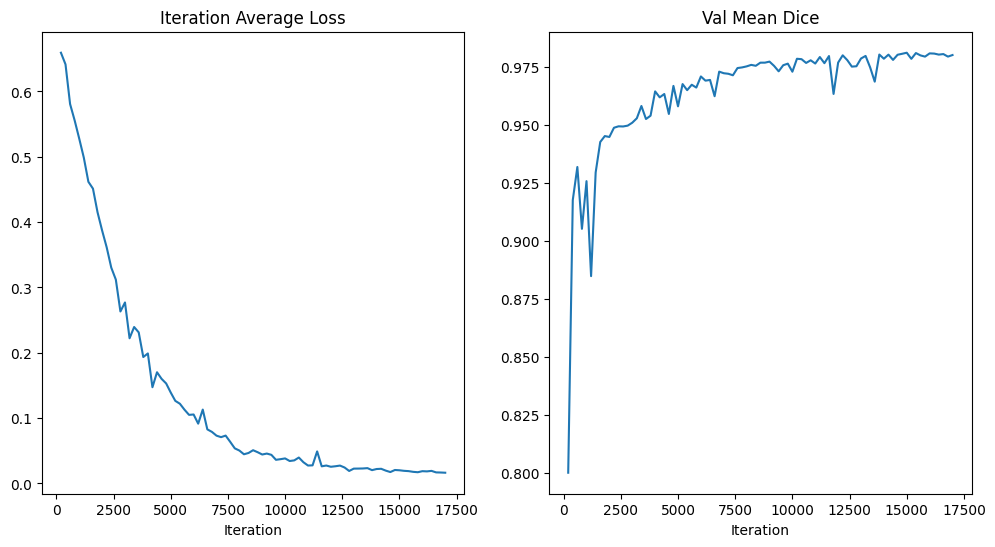

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_vnet_no_aug))]
#CHANGE PER MODEL
y = epoch_loss_values_vnet_no_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(metric_values_vnet_no_aug))]
#CHANGE PER MODEL
y = metric_values_vnet_no_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "metric_values_vnet_no_aug.npy")), np.array(metric_values_vnet_no_aug))
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_vnet_no_aug.npy")), np.array(epoch_loss_values_vnet_no_aug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_no_aug_best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"vnet_no_aug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 30.74it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"vnet_no_aug_best_metric_model.pth"))), strict=False)
model.eval()

VNet(
  (in_tr): InputTransition(
    (act_function): ELU(alpha=1.0, inplace=True)
    (conv_block): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (down_tr32): DownTransition(
    (down_conv): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_function1): ELU(alpha=1.0, inplace=True)
    (act_function2): ELU(alpha=1.0, inplace=True)
    (ops): Sequential(
      (0): LUConv(
        (act_function): ELU(alpha=1.0, inplace=True)
        (conv_block): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

0 261-img.nii.gz


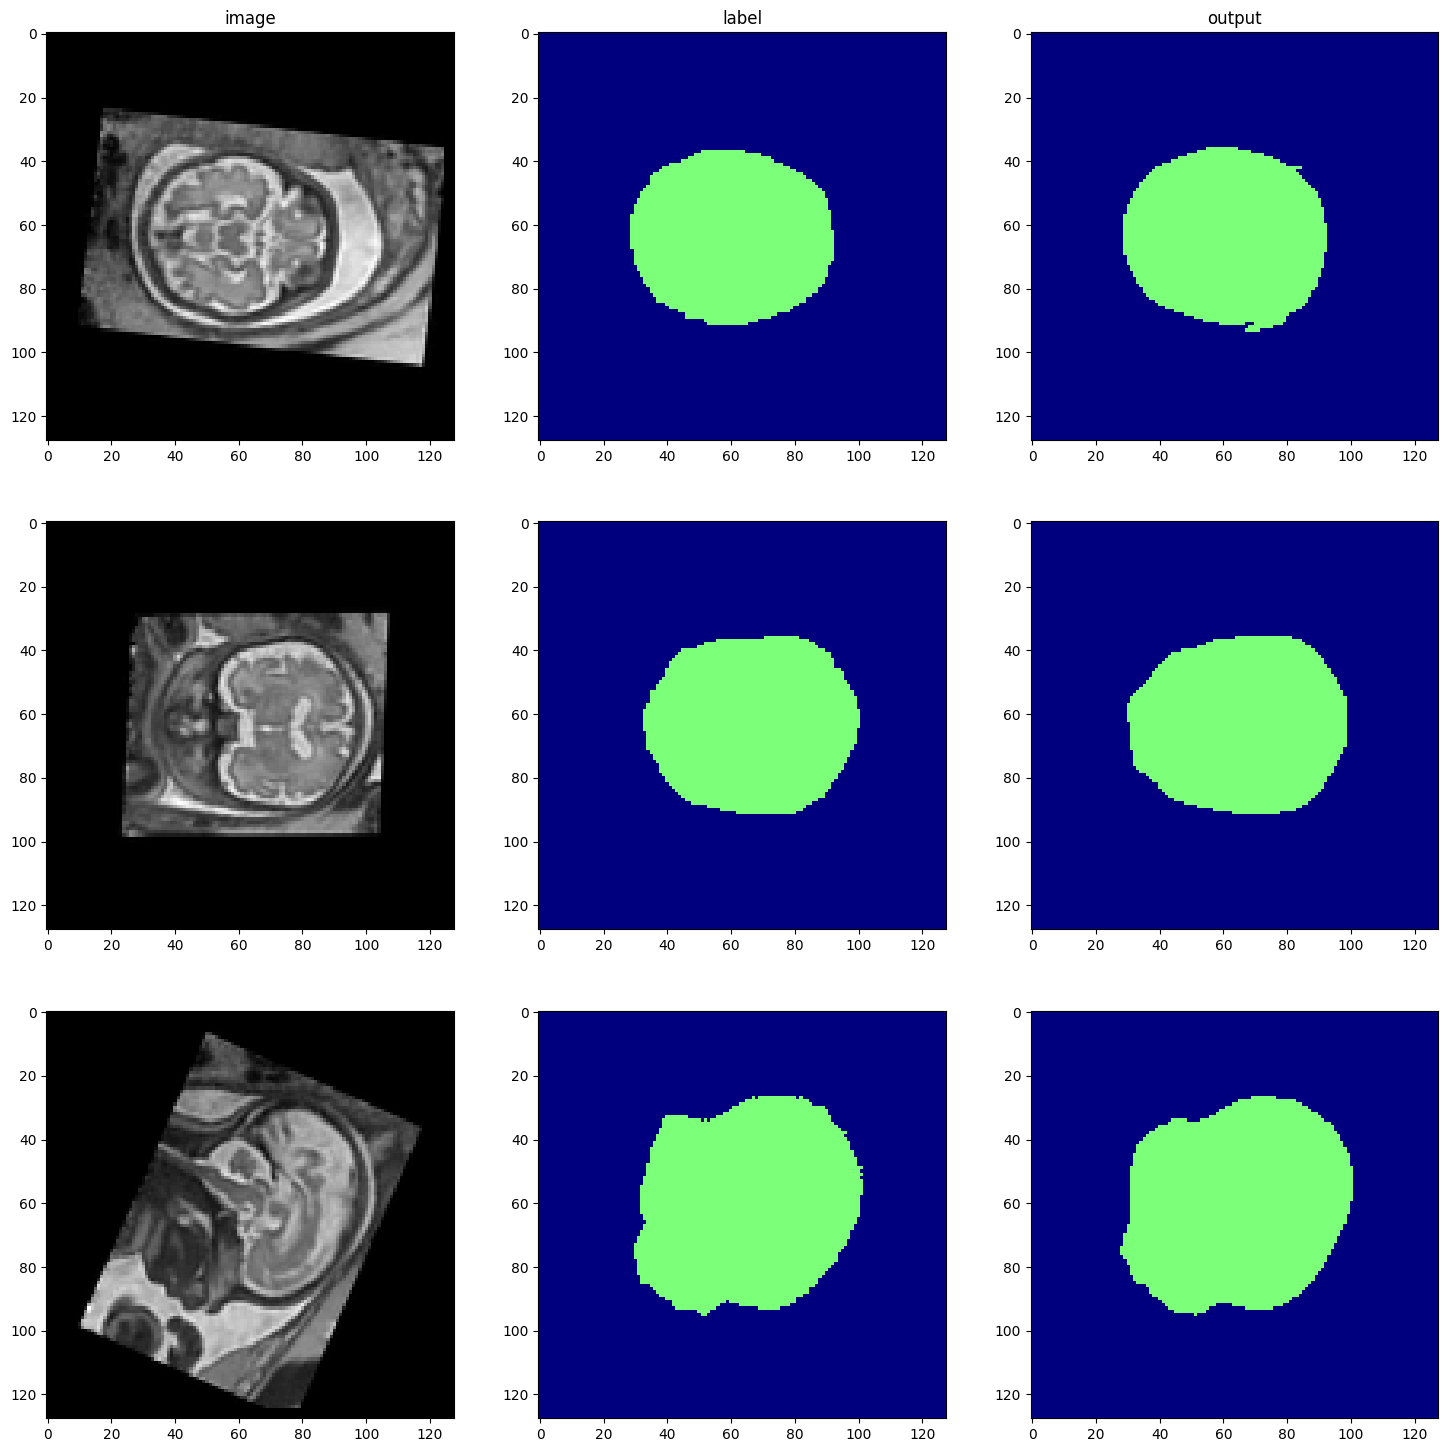

1 335-img.nii.gz


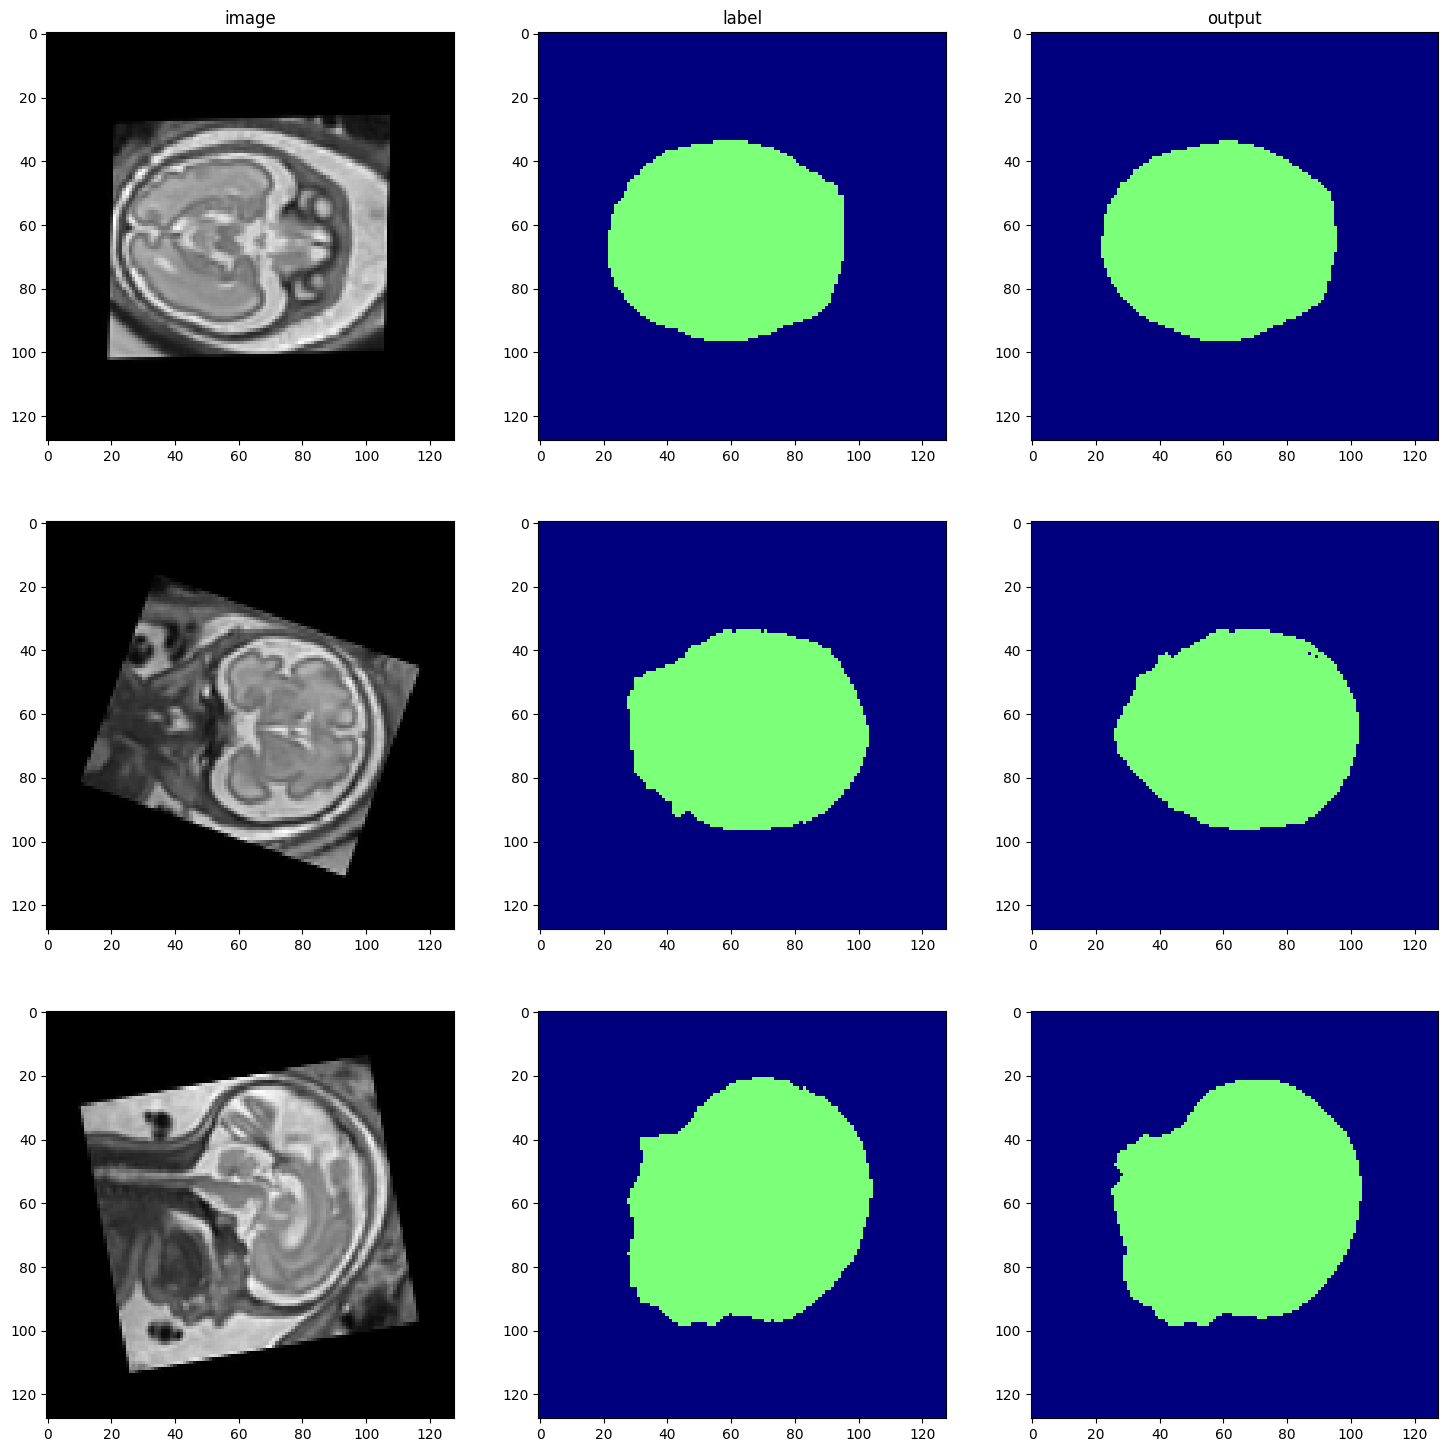

2 426-img.nii.gz


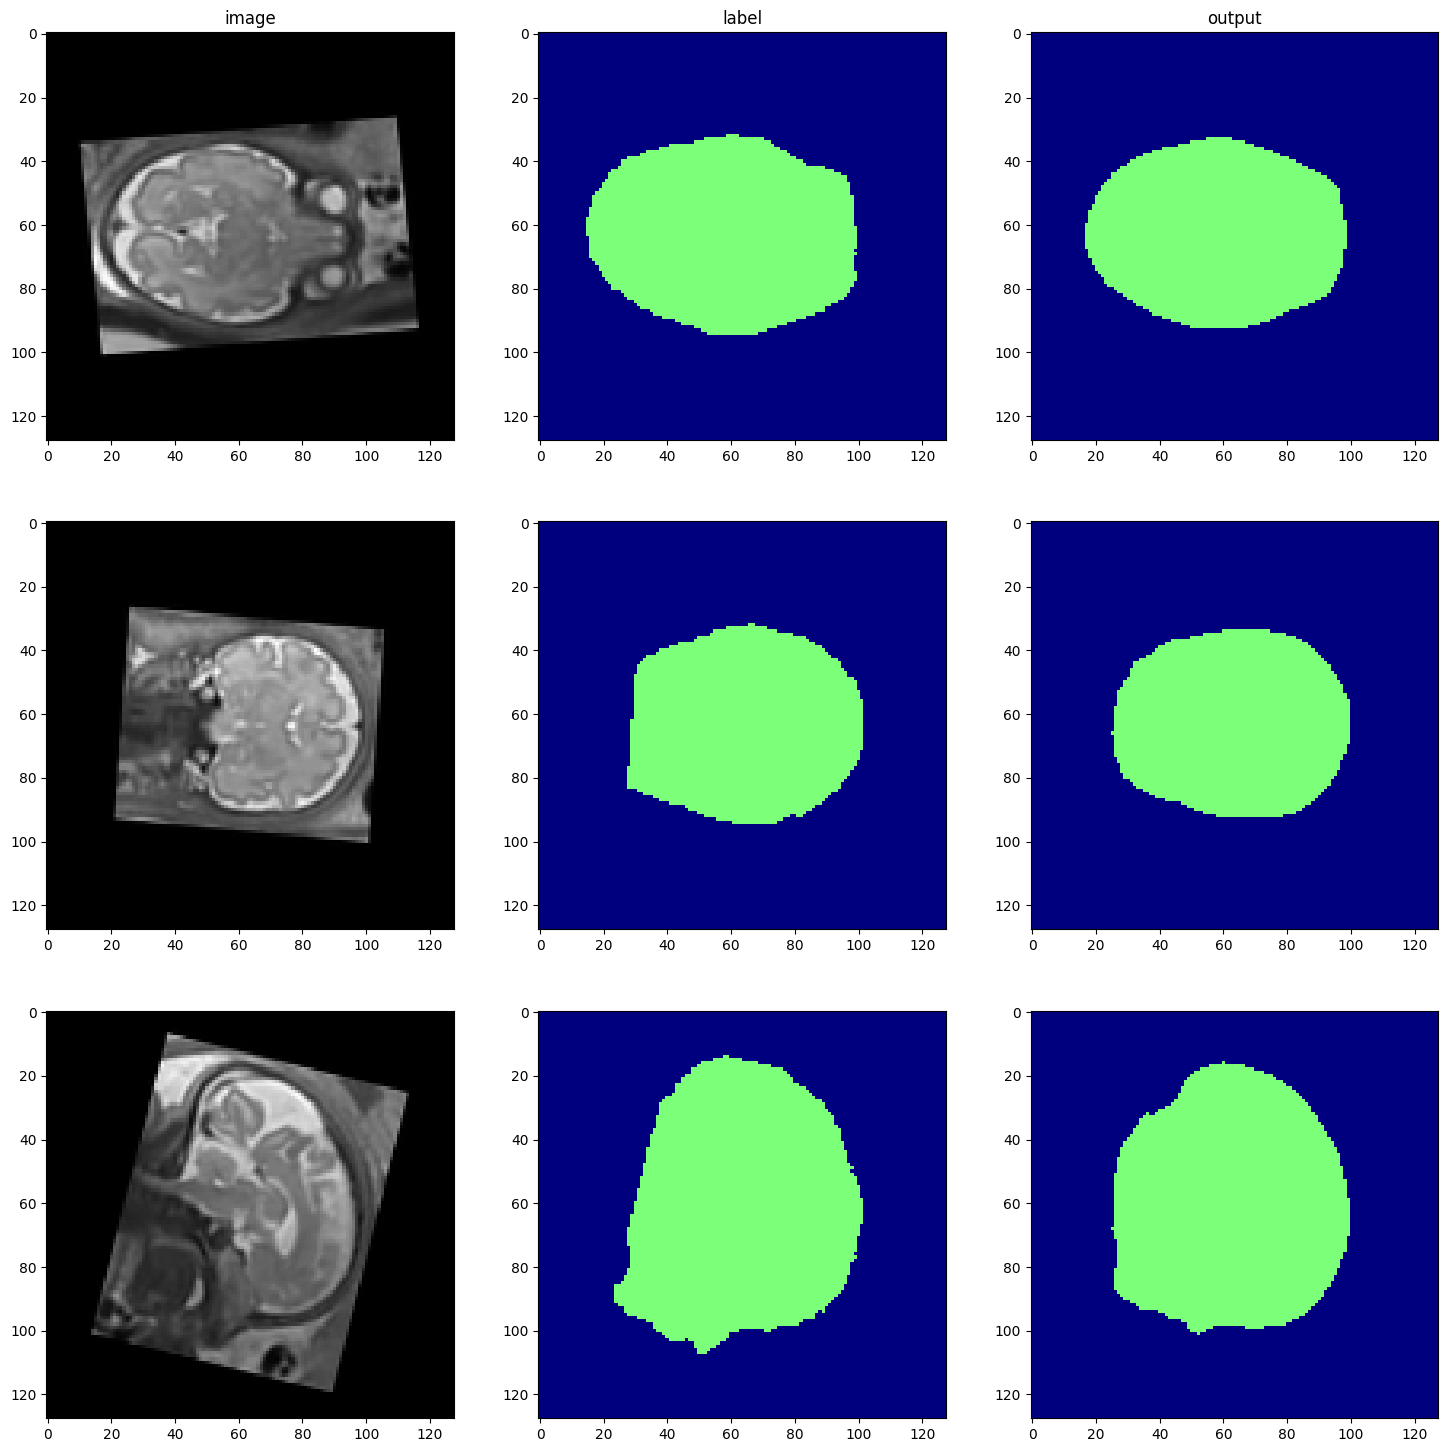

3 342-img.nii.gz


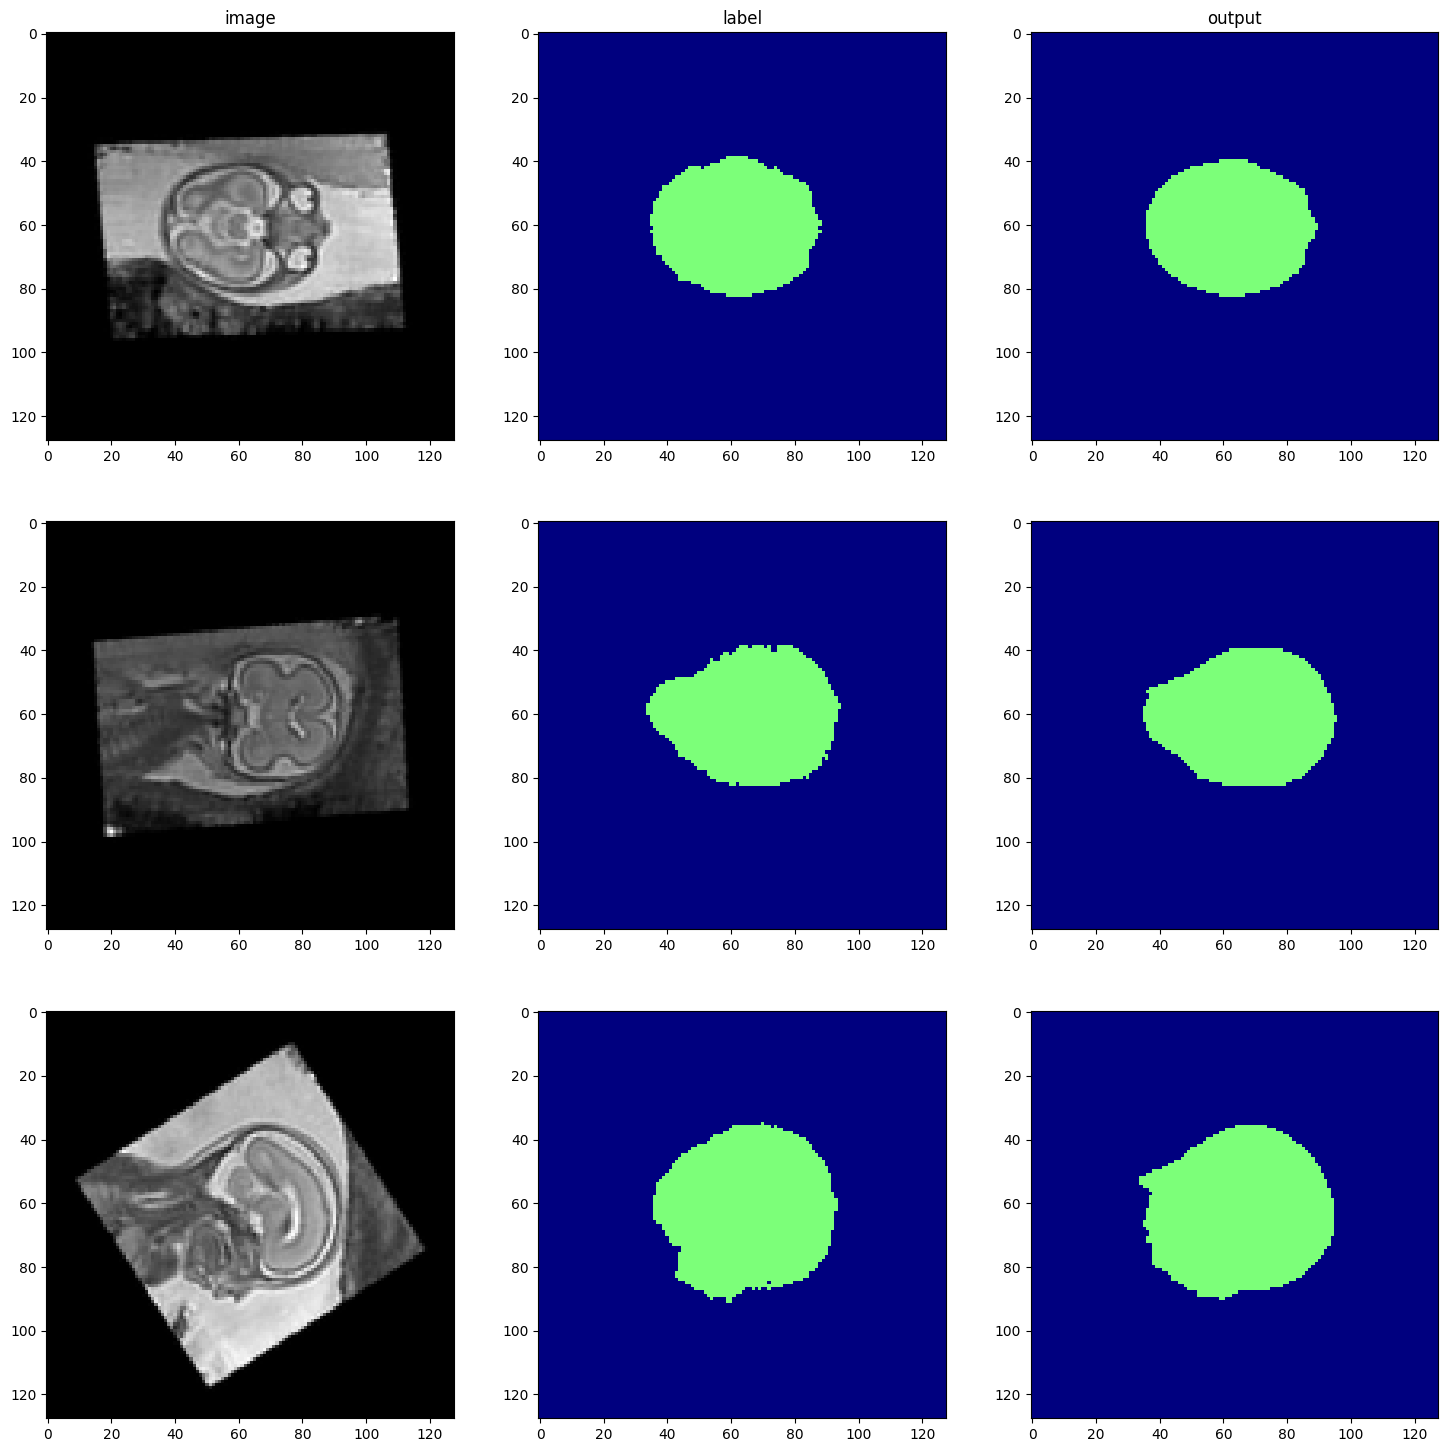

4 435-img.nii.gz


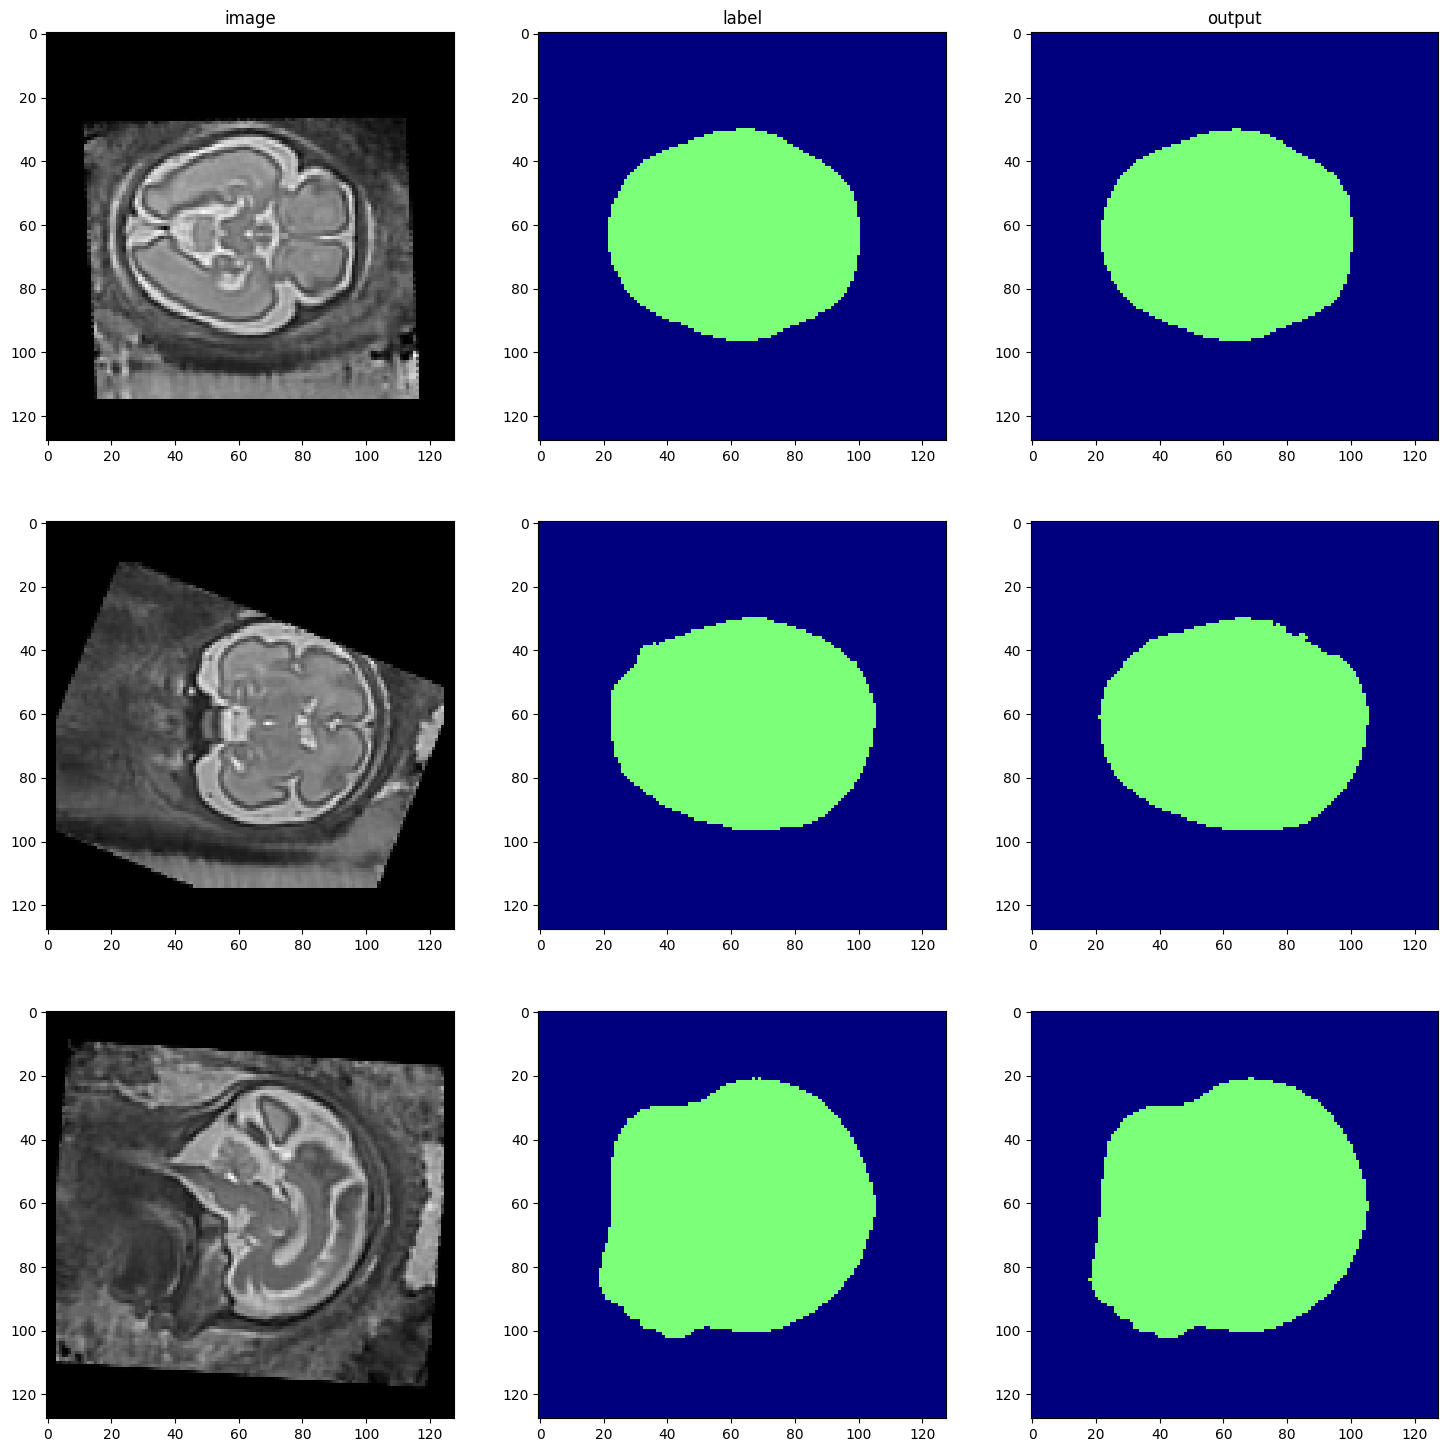

5 hist-136-img.nii.gz


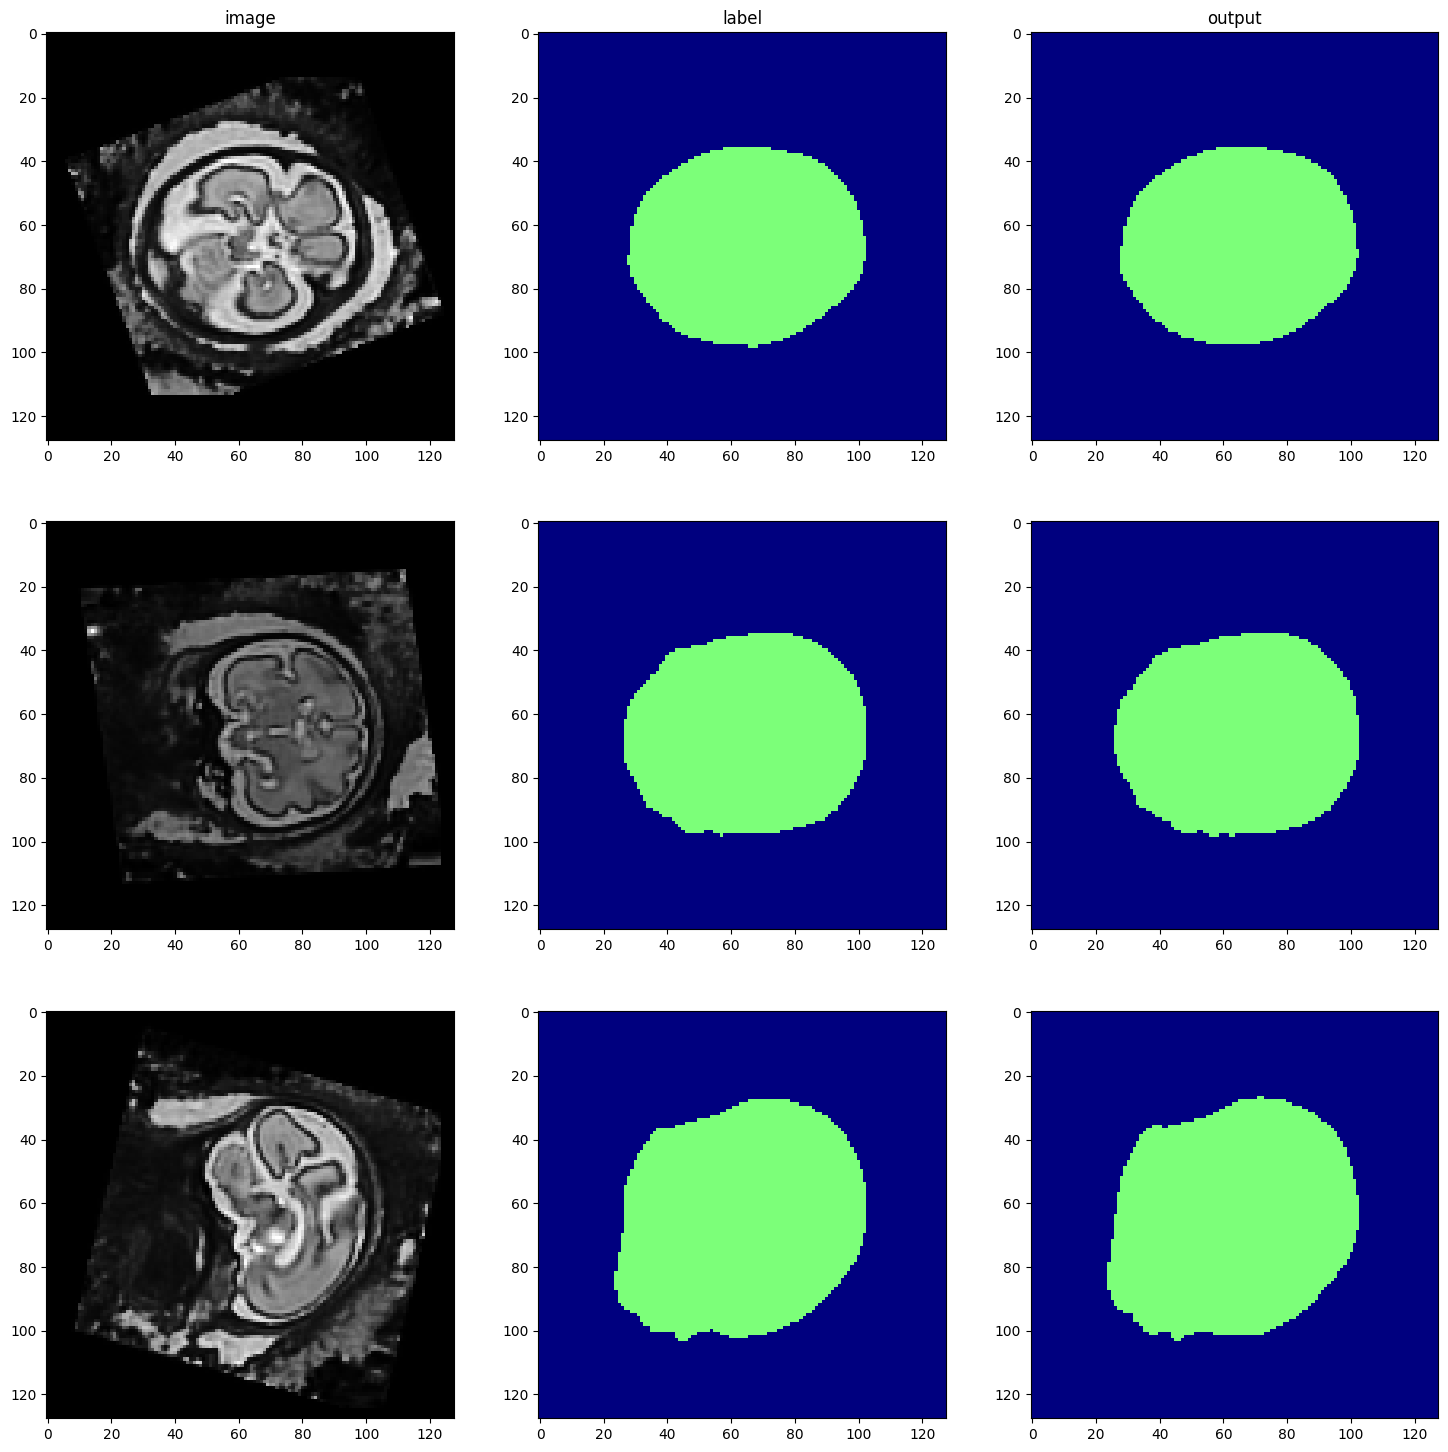

6 hist-214-img.nii.gz


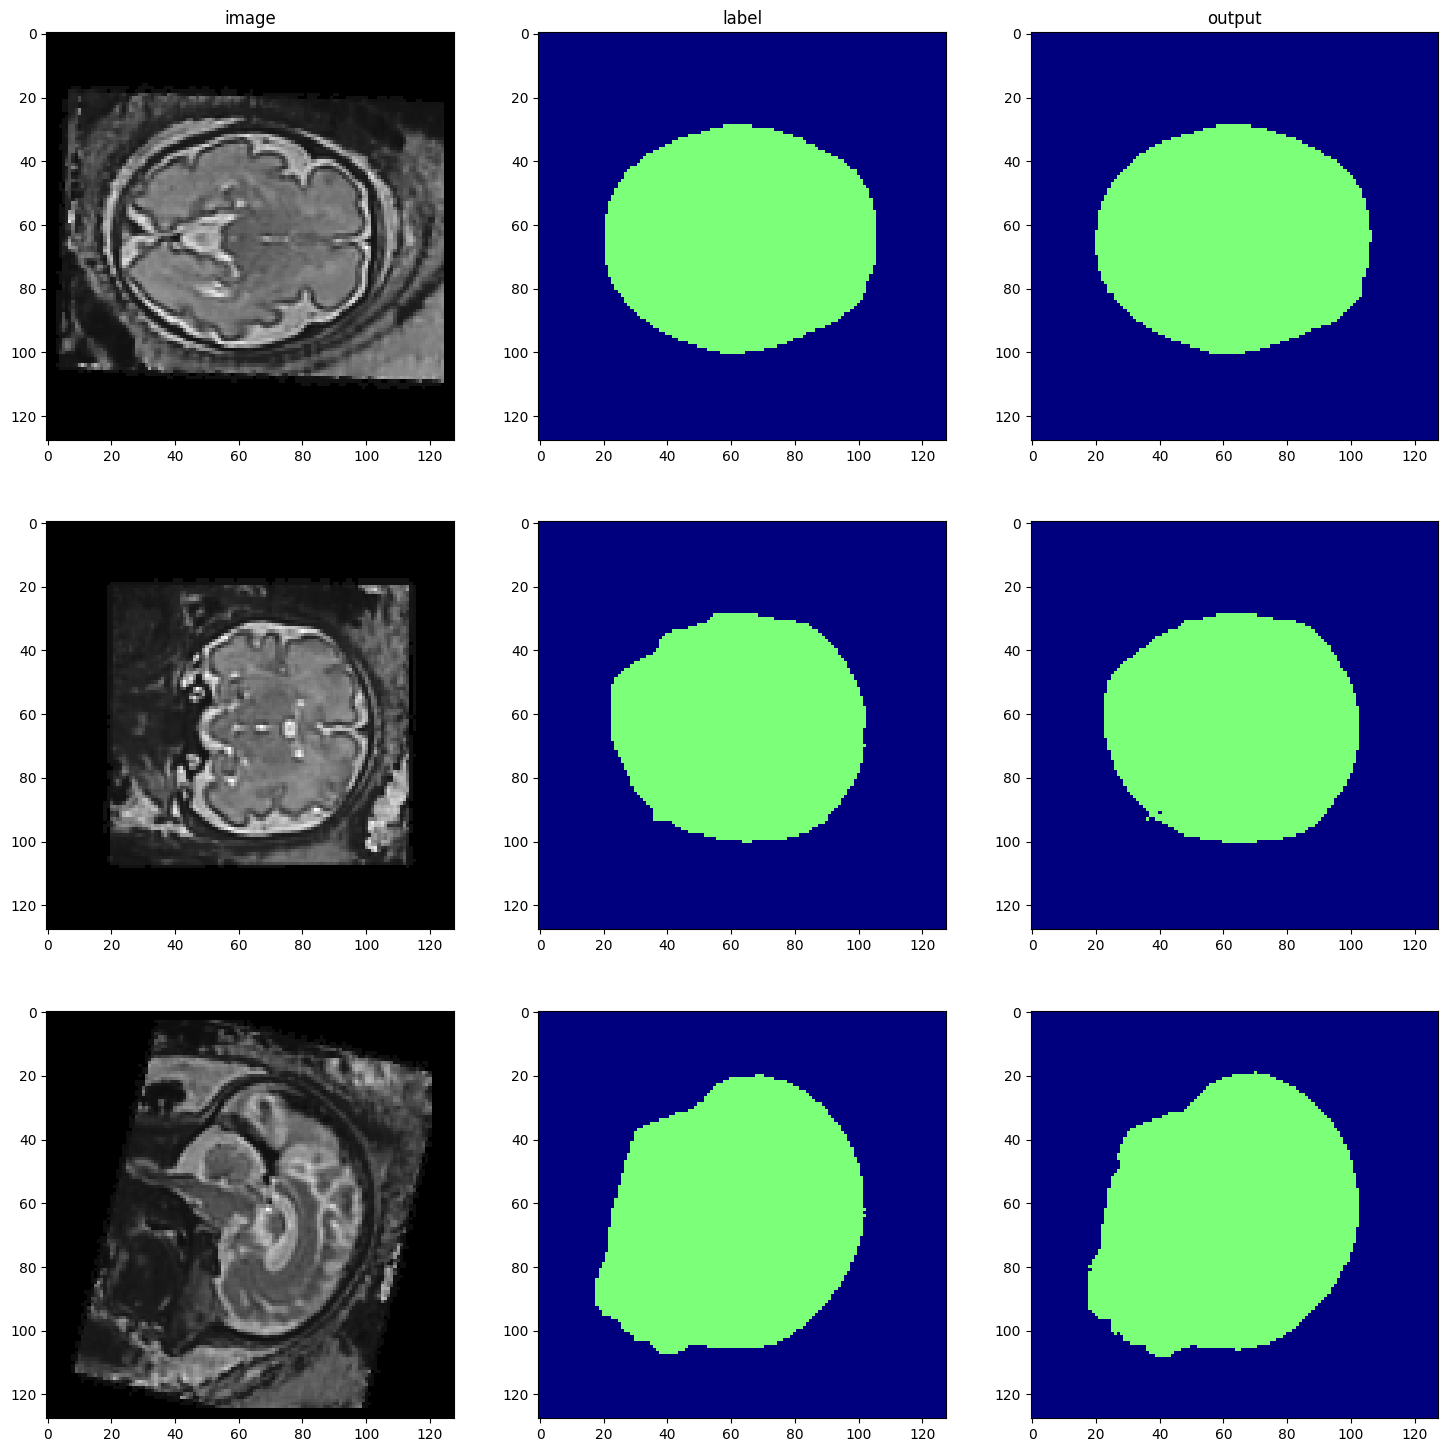

7 hist-236-img.nii.gz


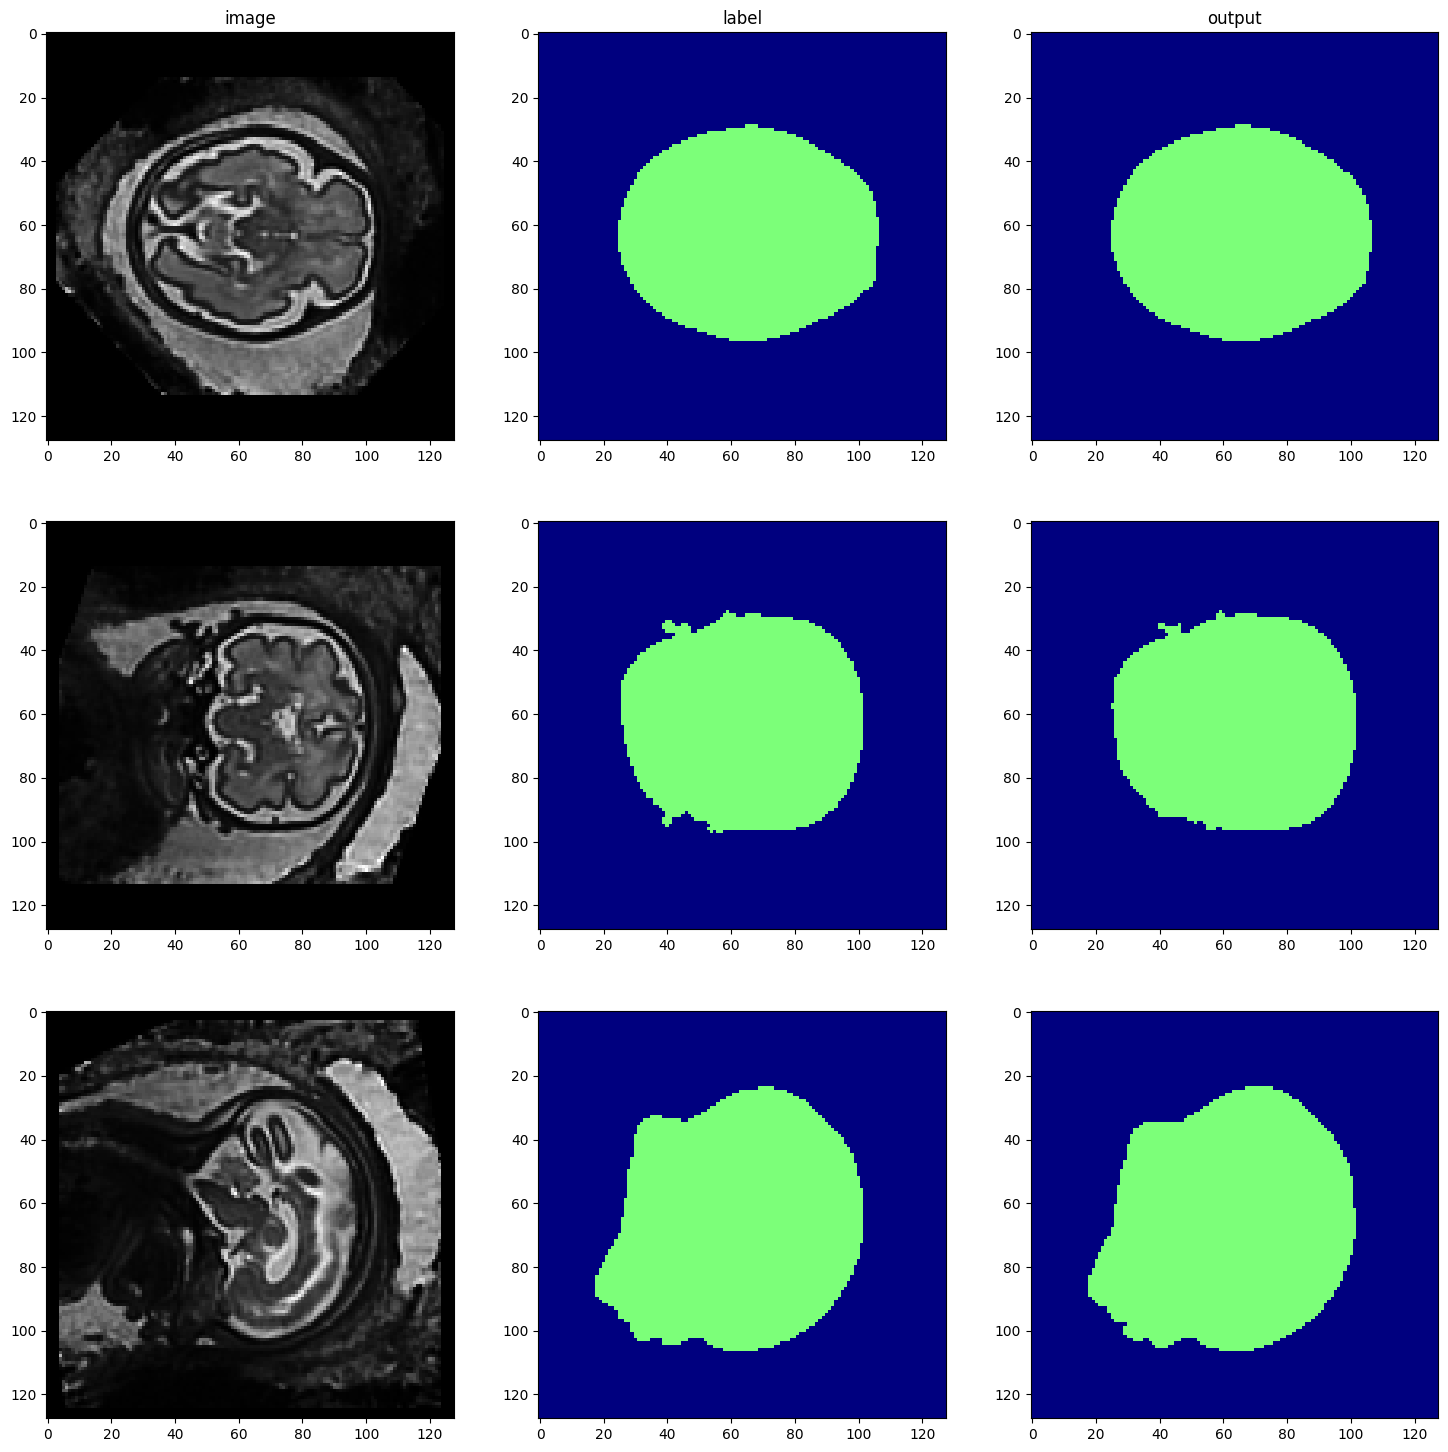

8 hist-253-img.nii.gz


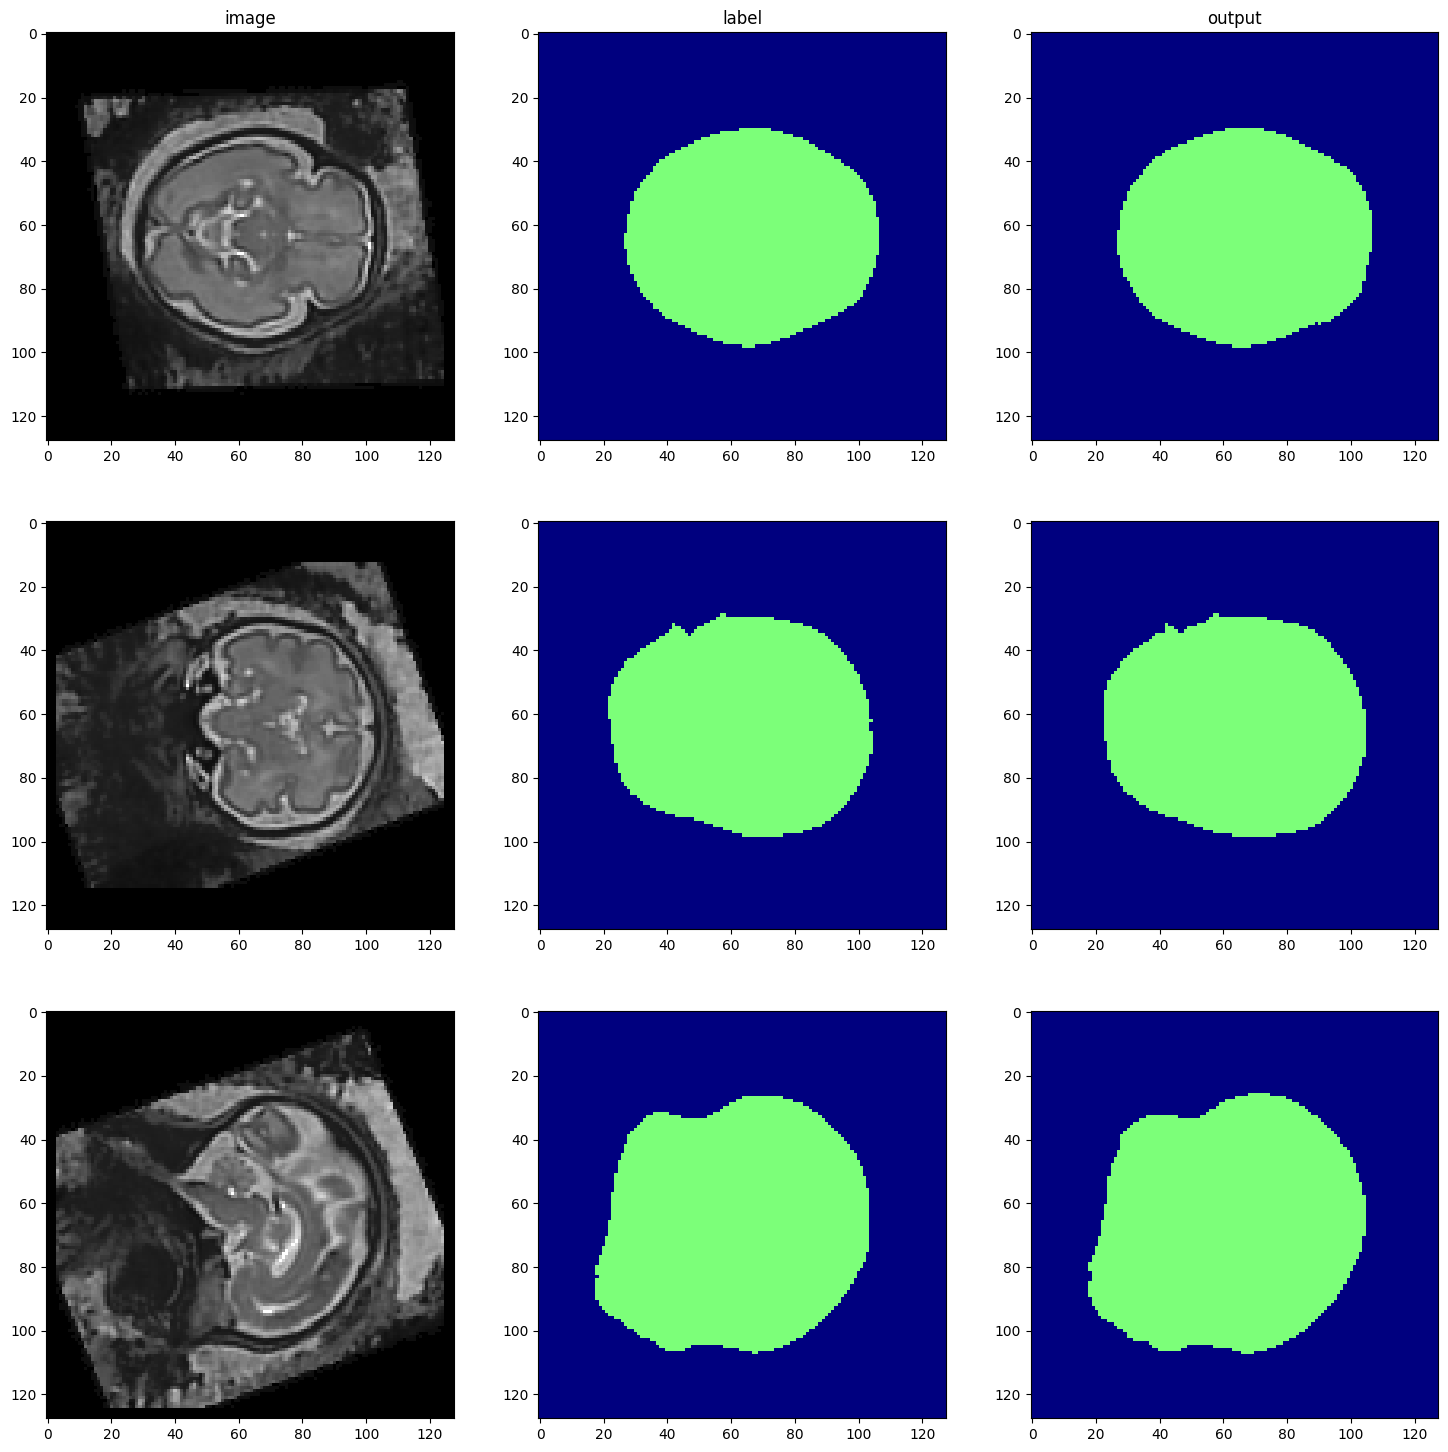

9 hist-275-img.nii.gz


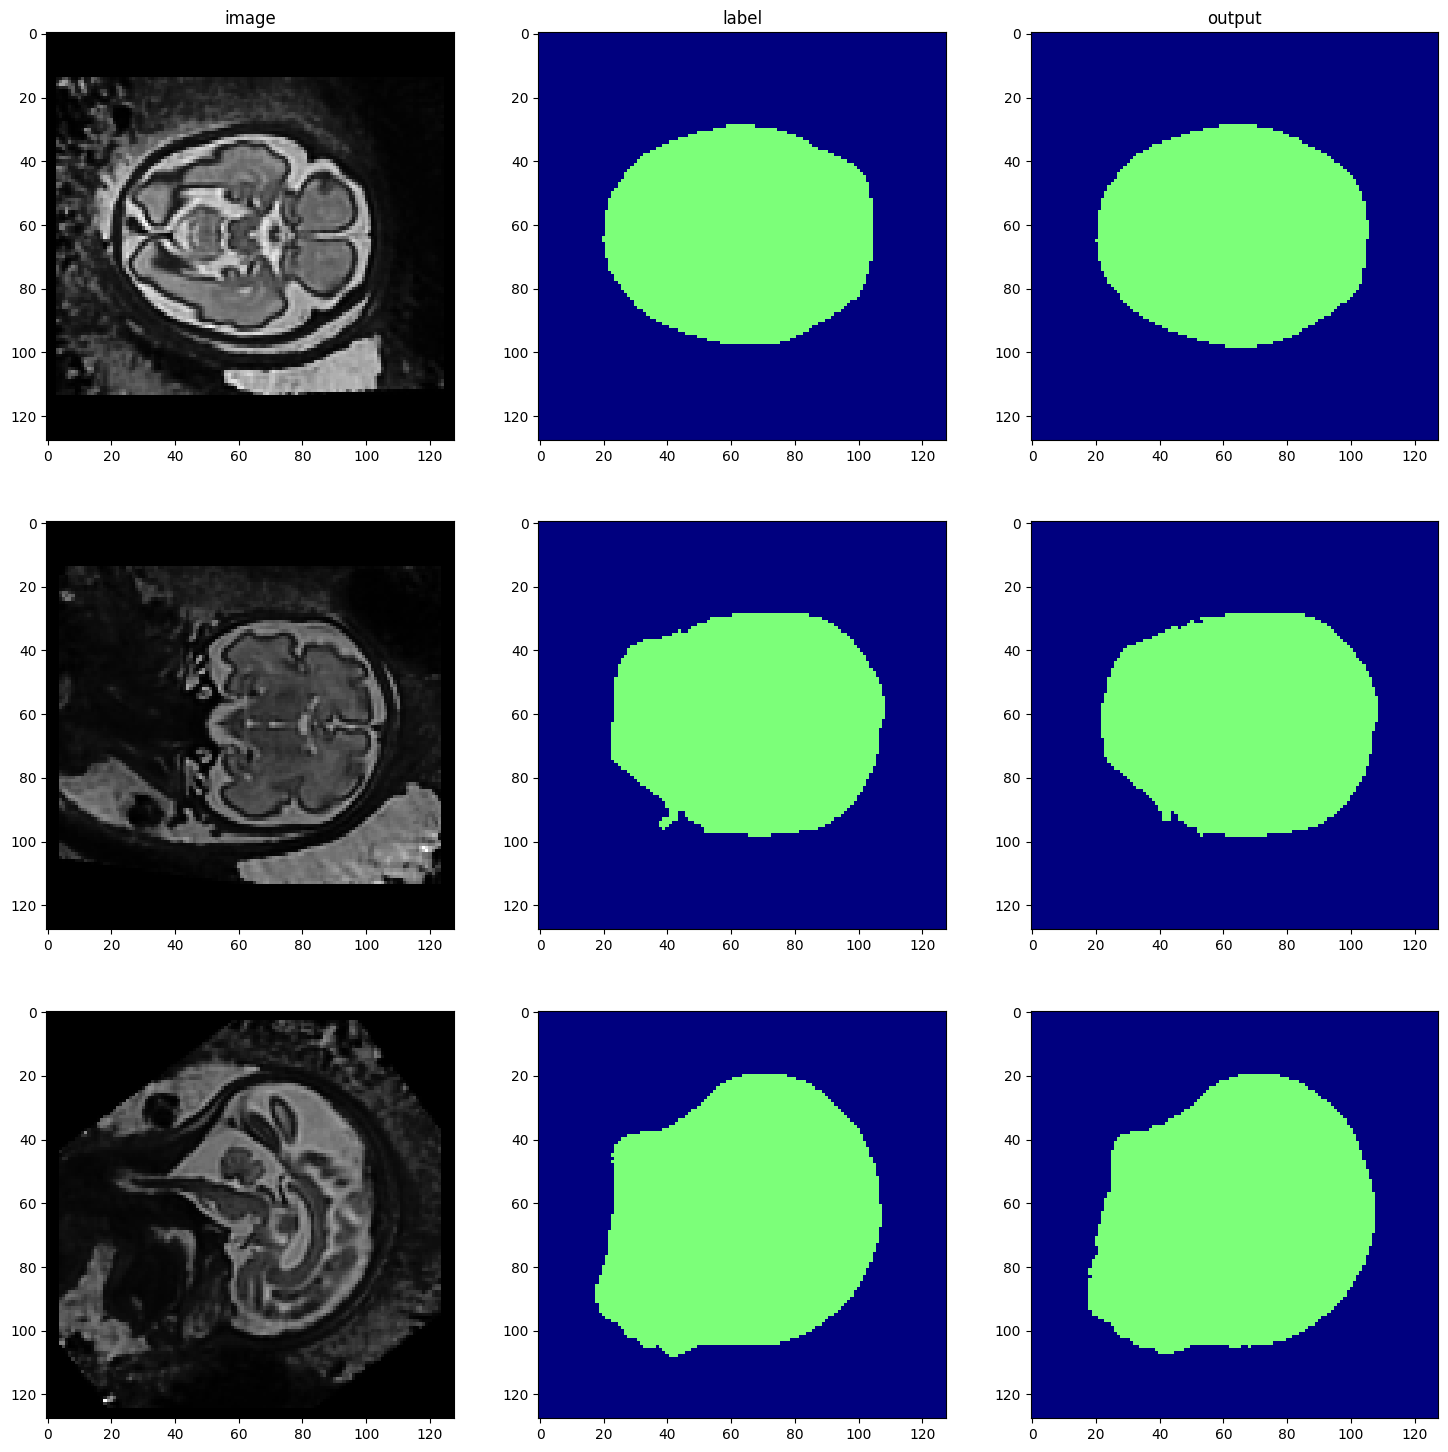

10 hist-292-img.nii.gz


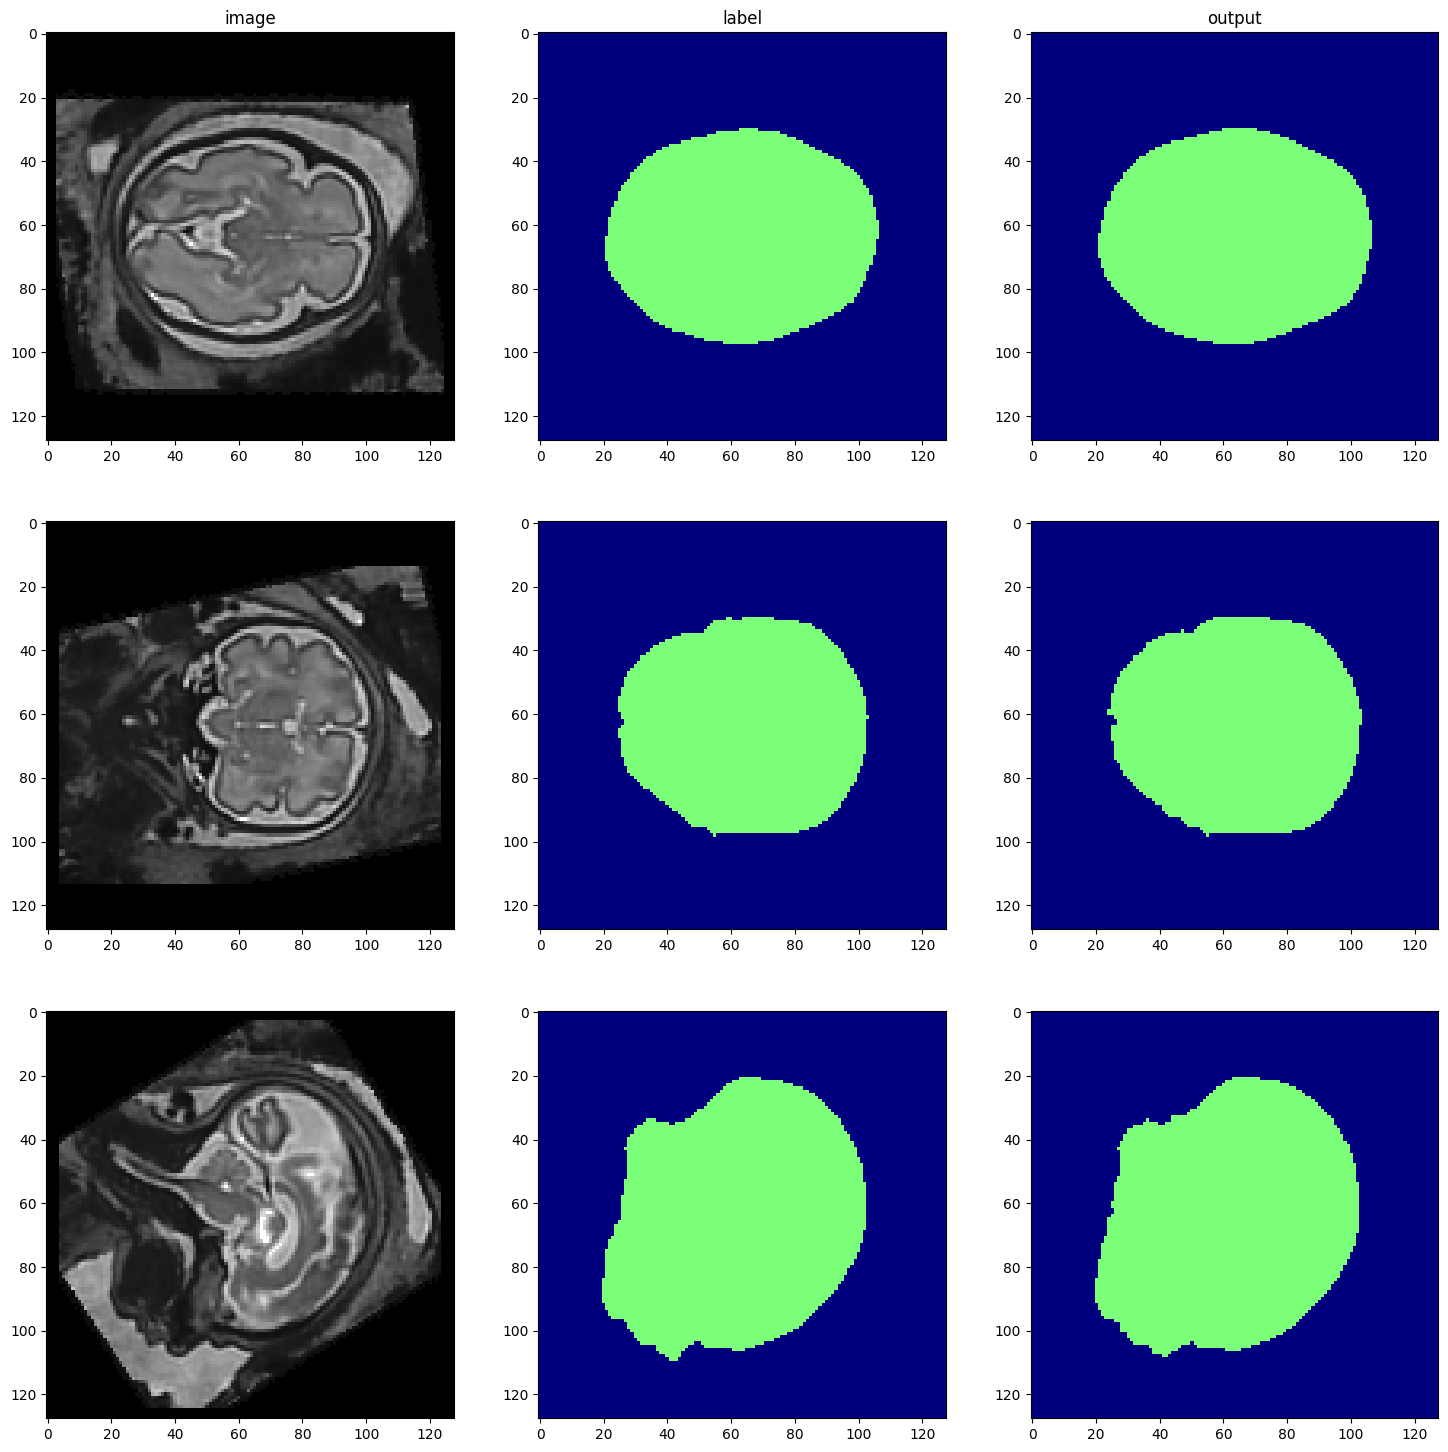

11 hist-355-img.nii.gz


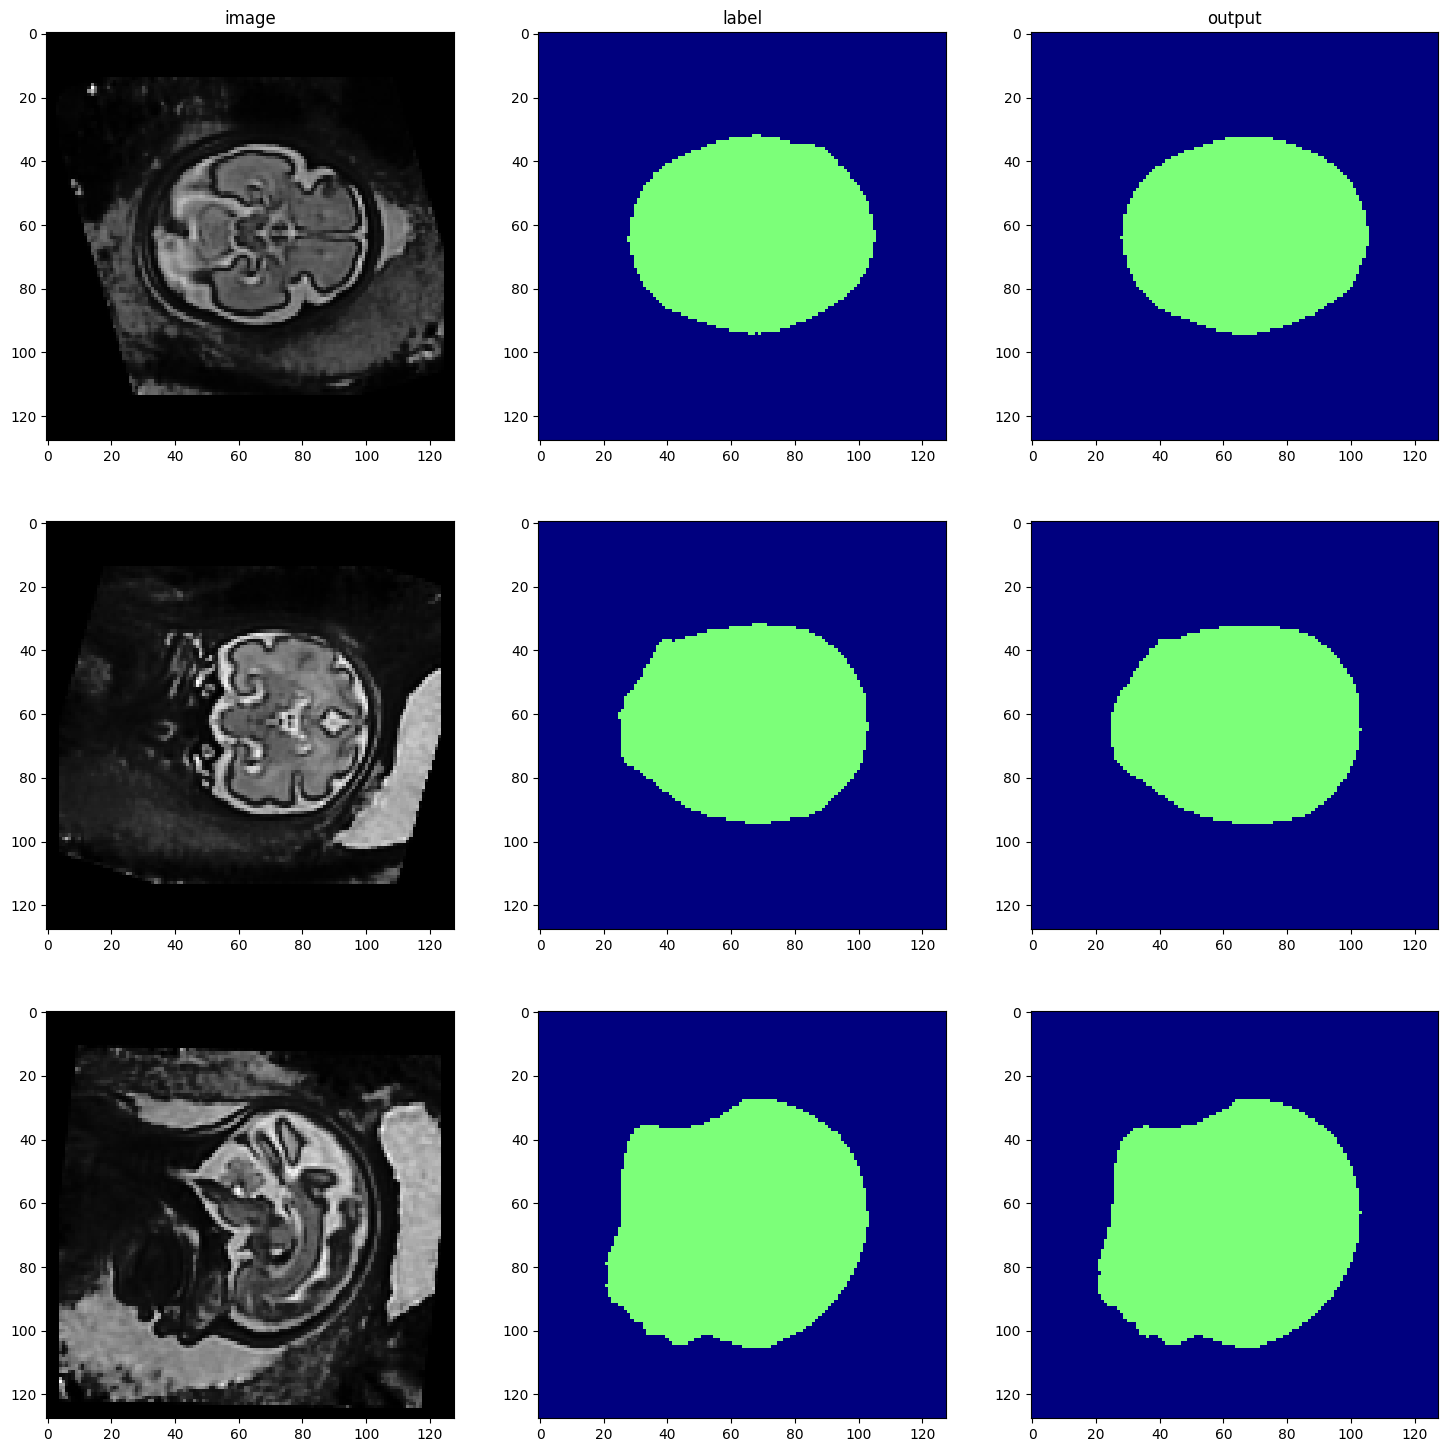

In [ ]:
class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()

In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "vnet_no_aug_results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)

0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_no_aug_results/cnn-lab-hist-236-img.nii.gz
8 /content/drive/MyDrive/face-seg-project-2023/new-traini